In [59]:
import imutils
from imutils import contours 
from skimage import measure  
import numpy as np          
import argparse
import cv2
import matplotlib.pyplot as plt
import os
import time

%matplotlib inline
from vlcs_mobile import copyVideo

# define our directions
class DIRECTIONS:
    LEFT_TO_RIGHT = "lr"
    RIGHT_TO_LEFT = "rl"
    TOP_TO_BOTTOM = "tb"
    BOTTOM_TO_TOP = "bt"

# define modes
class MODES:
    VIDEO = "video"
    IMAGE = "image"

In [60]:
def plot_imshow_in_array(matrices_to_show:list , max_image_in_row:int = 4 , plots_kwargs_list:list = []):
    """
        Plots the image list in an array of row * col , where max(col) = max_image_in_row, and the 
        number of rows is calculated accordingly. 
        @param matrices_to_show a list of matrices to be plotted using plt.imshow
        @param max_image_in_row maximum number of plots in one row
        @param plots_kwargs_list list of dictionaries of parameters of each plot
        
    """    
    ## total number of plots
    plot_count = len(matrices_to_show)
    
    assert len(plots_kwargs_list) == 0 or len(plots_kwargs_list) == len(matrices_to_show) , """ plots_kwargs_list should be either an empty 
                                                                                    list or should have the same number of members
                                                                                    as matrices_to_show """
    
    ## number of rows
    nrow = plot_count // max_image_in_row + (1 if (plot_count % max_image_in_row > 0) else 0)
    
    ## number of columns
    ncol = max_image_in_row if plot_count >= max_image_in_row else plot_count
    
    ## plotting using imshow
    fig , ax = plt.subplots(nrow , ncol , figsize = (12 , 6))
    for i in range(plot_count):
        
        ## select the subplot
        plt.subplot(nrow , ncol , i+1 )
        
        ## format the argument dictionary of the imshow function
        if(len(plots_kwargs_list) == 0):
            config_dict = {}
        else: 
            config_dict = plots_kwargs_list[i]
        
        ## pass the image as well as extra arguments to the imshow function
        plt.imshow(matrices_to_show[i] , **config_dict)
        
    return fig , ax 
    

In [65]:
def split_video(input_video_path, output_folder):
    # open the video
    cap = cv2.VideoCapture(input_video_path)
    
    # get the fps of video
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # calculate frames per second
    frames_per_second = fps
    frames_per_clip = frames_per_second * 1
    
    for i in range(4):
        output_video_path = f"{output_folder}/clip_{i+1}.mp4"
        writer = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (int(cap.get(3)),int(cap.get(4))))

        for _ in range(frames_per_clip):
            ret, frame = cap.read()
            if not ret:
                break
            writer.write(frame)

        writer.release()
    cap.release()

In [67]:
split_video("./resources/rolling_shutter.mp4", "rolling_shutter")

In [49]:
def ApplyRollingShutterToFrame(videoCap, framesIncrement, direction, mode):
    WIDTH = int(videoCap.get(cv2.CAP_PROP_FRAME_WIDTH))
    HEIGHT = int(videoCap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    FPS = int(videoCap.get(cv2.CAP_PROP_FPS))

    success, frozenFrame = videoCap.read()

    if success:
        print("Video read successfully")
    else:
        print("Video read failed")

    # Define the LED area dimensions (adjust as needed)
    led_area_width = 600  # 闪烁的LED区域宽度
    led_area_height = 400  # 闪烁的LED区域高度

    # Calculate LED area position
    led_area_x = (WIDTH - led_area_width) // 2
    led_area_y = (HEIGHT - led_area_height) // 2

    # Create our video writer
    writer = cv2.VideoWriter()
    writer.open('video.mp4', cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), FPS, (WIDTH, HEIGHT), True)

    success, currentFrame = videoCap.read()
    framesRead = 1

    while success:
        print("Processing frame: " + str(framesRead))

        # Calculate the effective range for the rolling shutter effect
        effective_range = min(led_area_height, framesRead)

        if direction == DIRECTIONS.LEFT_TO_RIGHT:
            frozenFrame[led_area_y:led_area_y+led_area_height, led_area_x+effective_range:led_area_x+led_area_width] = currentFrame[led_area_y:led_area_y+led_area_height, led_area_x+effective_range:led_area_x+led_area_width]

        elif direction == DIRECTIONS.RIGHT_TO_LEFT:
            frozenFrame[led_area_y:led_area_y+led_area_height, led_area_x:led_area_x+led_area_width-effective_range] = currentFrame[led_area_y:led_area_y+led_area_height, led_area_x:led_area_x+led_area_width-effective_range]

        elif direction == DIRECTIONS.TOP_TO_BOTTOM:
            frozenFrame[led_area_y+effective_range:led_area_y+led_area_height, led_area_x:led_area_x+led_area_width] = currentFrame[led_area_y+effective_range:led_area_y+led_area_height, led_area_x:led_area_x+led_area_width]

        elif direction == DIRECTIONS.BOTTOM_TO_TOP:
            frozenFrame[led_area_y:led_area_y+led_area_height-effective_range, led_area_x:led_area_x+led_area_width] = currentFrame[led_area_y:led_area_y+led_area_height-effective_range, led_area_x:led_area_x+led_area_width]

        if mode == MODES.VIDEO:
            writer.write(frozenFrame)

        success, currentFrame = videoCap.read()
        framesRead += framesIncrement

    if not success:
        print("Success :) Looks like we've run out of frames")
    else:
        print("Success :) Looks like we've hit the end of our frame")

    if mode == MODES.IMAGE:
        cv2.imwrite("frame.jpg", frozenFrame)

    print("Writing video...")
    writer.release()

    return None


In [50]:
video = "./resources/rolling_shutter.mp4"
cap = cv2.VideoCapture(video)
FRAMES_INCREMEN = 2
DIRECTION = "tb"
MODE = "video"

image = ApplyRollingShutterToFrame(cap, FRAMES_INCREMEN, DIRECTION, MODE)

Video read successfully
Processing frame: 1
Processing frame: 3
Processing frame: 5
Processing frame: 7
Processing frame: 9
Processing frame: 11
Processing frame: 13
Processing frame: 15
Processing frame: 17
Processing frame: 19
Processing frame: 21
Processing frame: 23
Processing frame: 25
Processing frame: 27
Processing frame: 29
Processing frame: 31
Processing frame: 33
Processing frame: 35
Processing frame: 37
Processing frame: 39
Processing frame: 41
Processing frame: 43
Processing frame: 45
Processing frame: 47
Processing frame: 49
Processing frame: 51
Processing frame: 53
Processing frame: 55
Processing frame: 57
Processing frame: 59
Processing frame: 61
Processing frame: 63
Processing frame: 65
Processing frame: 67
Processing frame: 69
Processing frame: 71
Processing frame: 73
Processing frame: 75
Processing frame: 77
Processing frame: 79
Processing frame: 81
Processing frame: 83
Processing frame: 85
Processing frame: 87
Processing frame: 89
Processing frame: 91
Processing fram

255


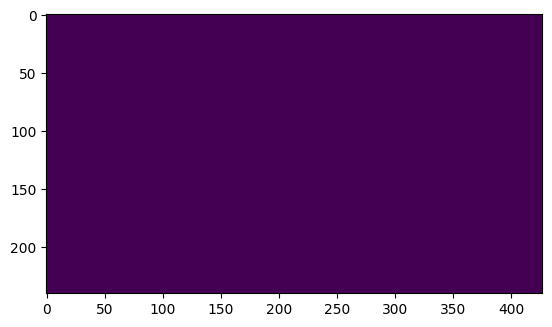

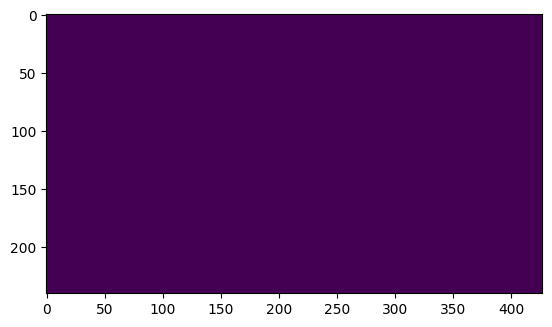

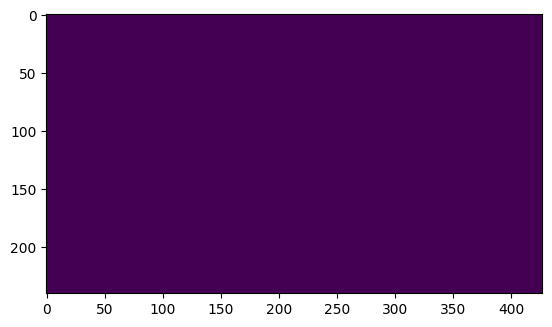

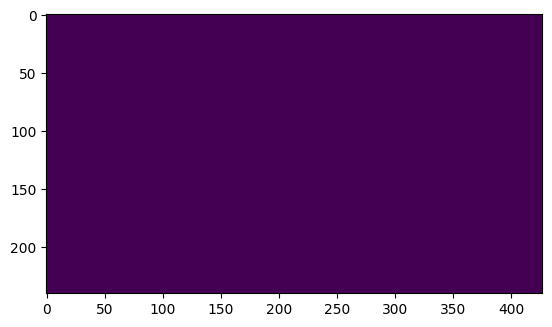

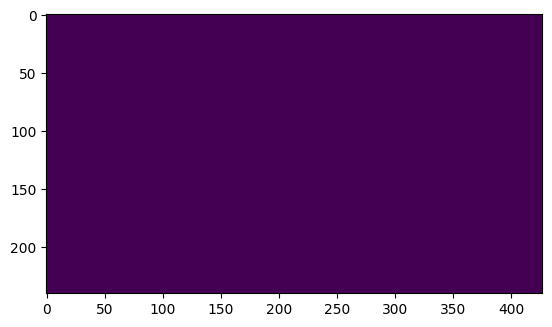

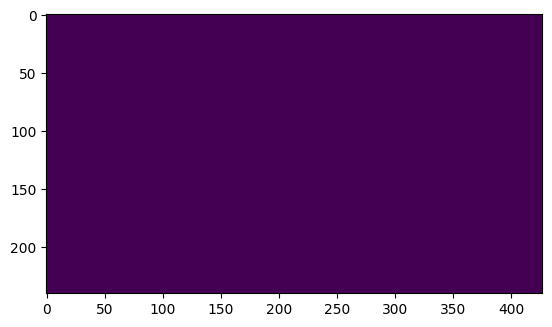

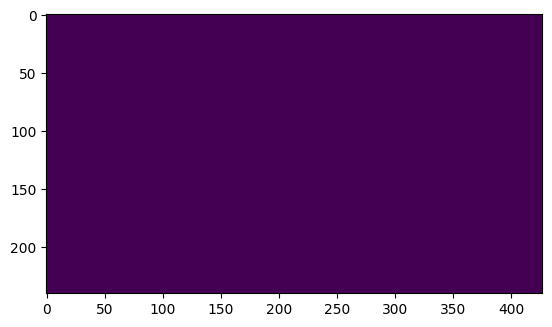

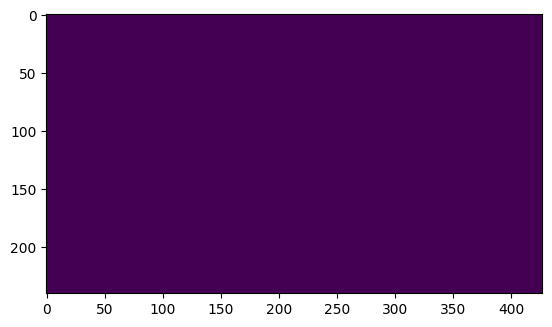

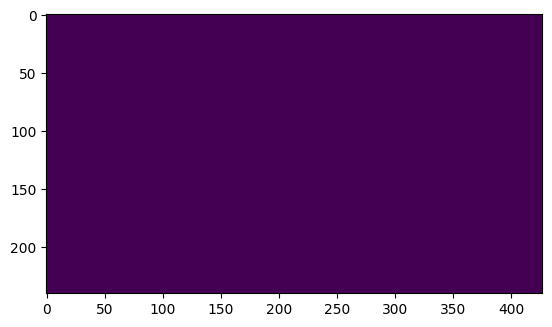

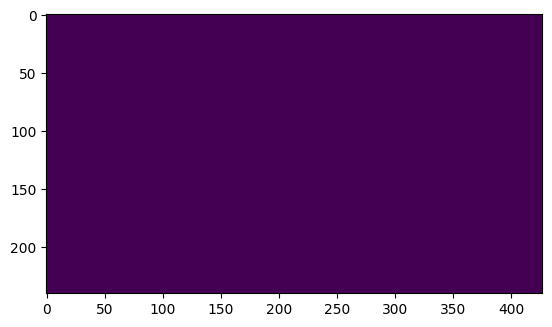

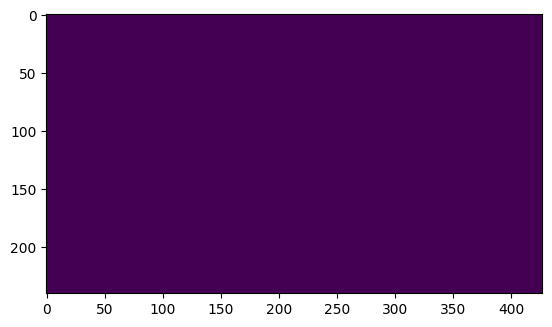

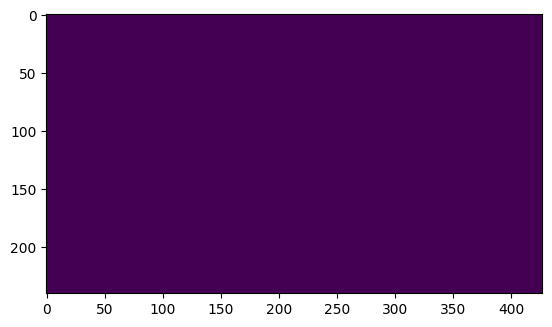

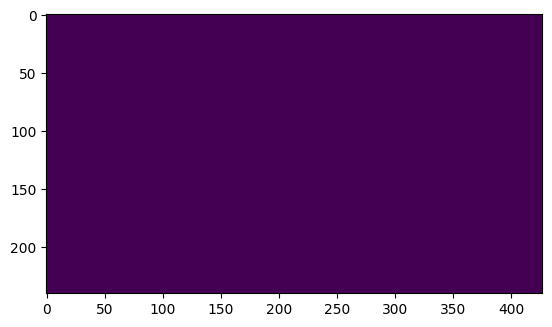

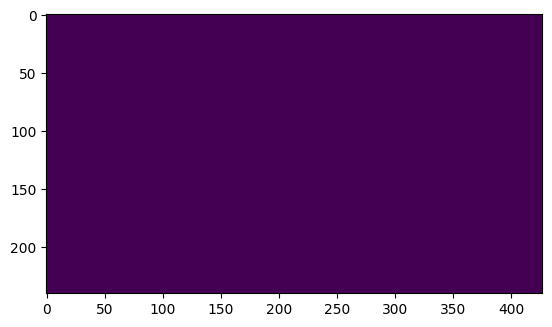

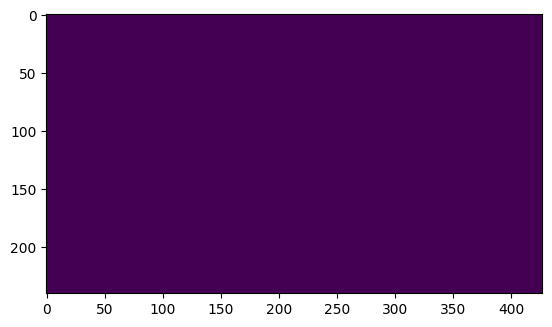

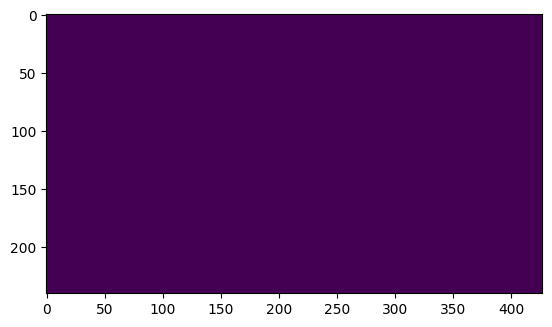

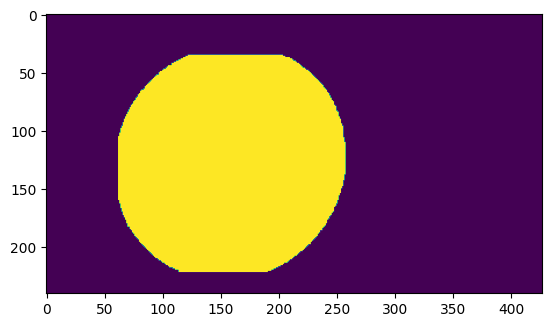

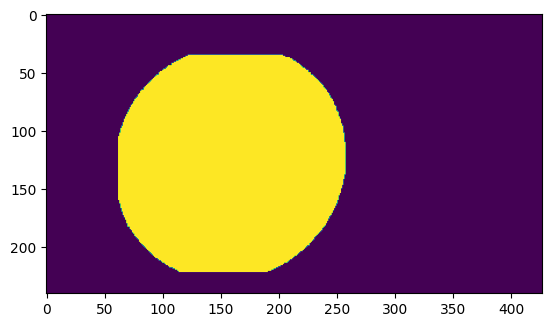

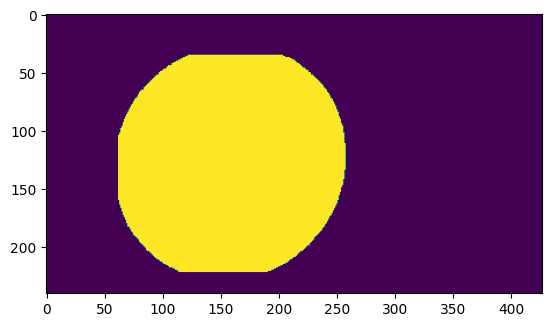

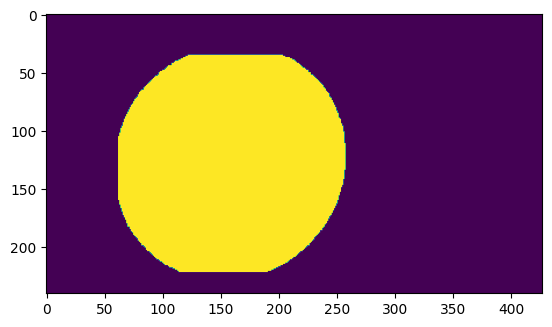

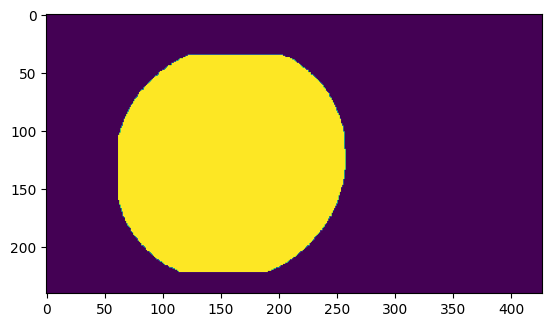

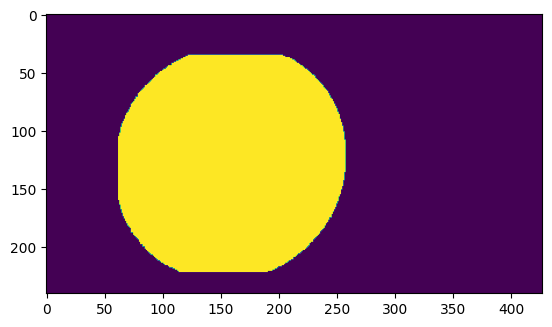

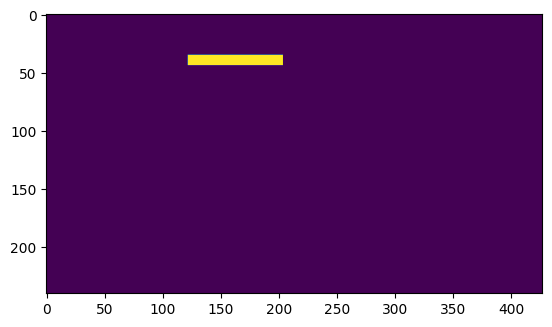

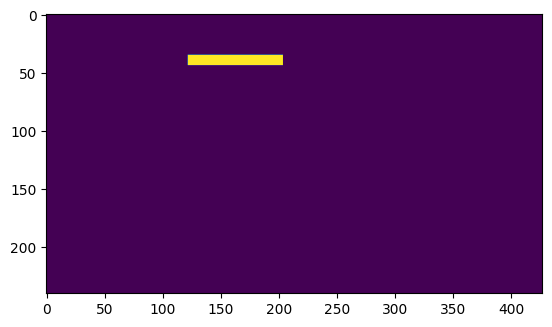

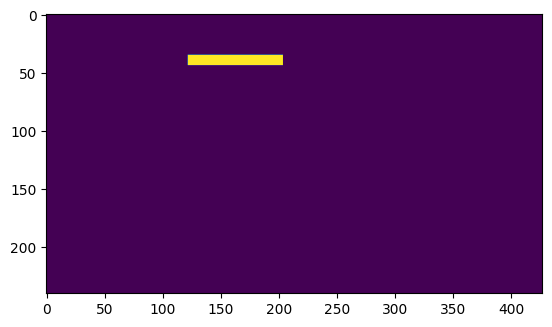

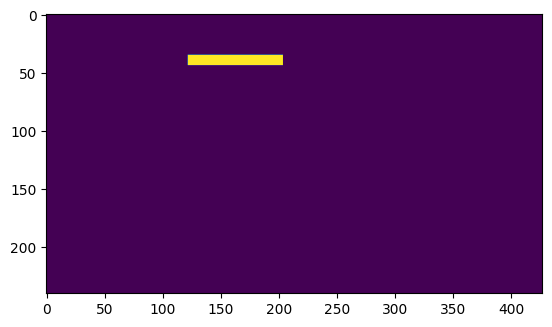

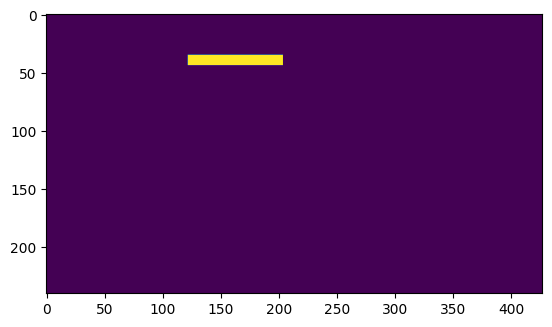

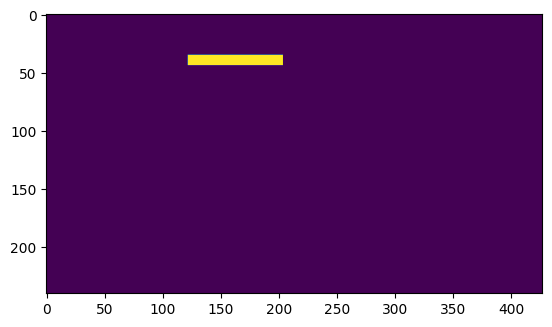

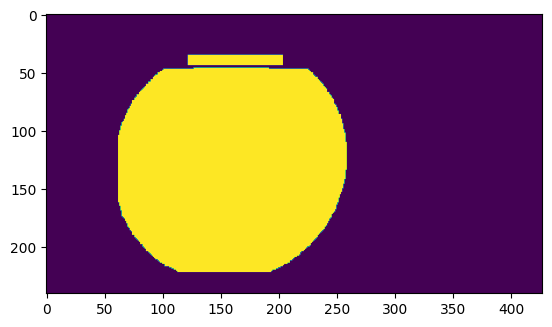

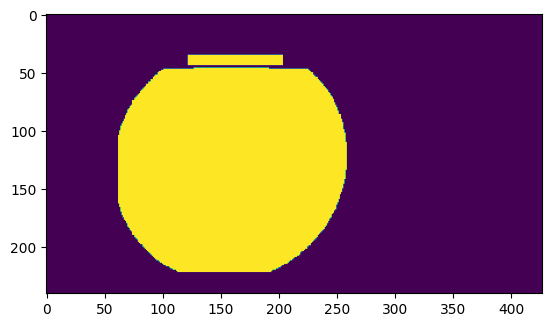

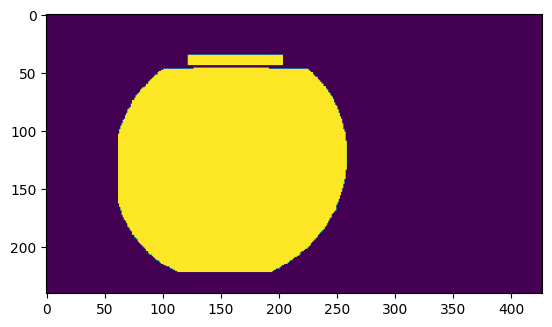

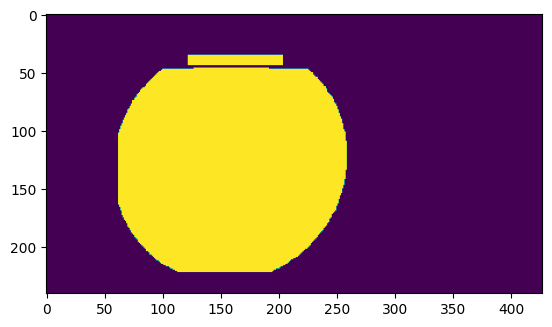

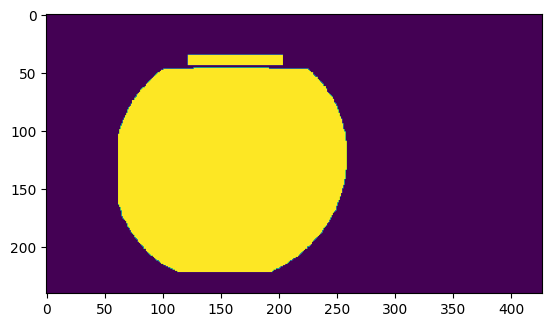

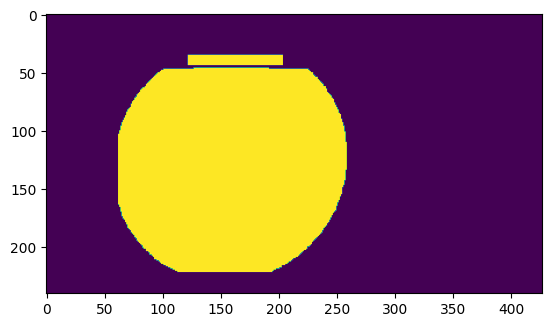

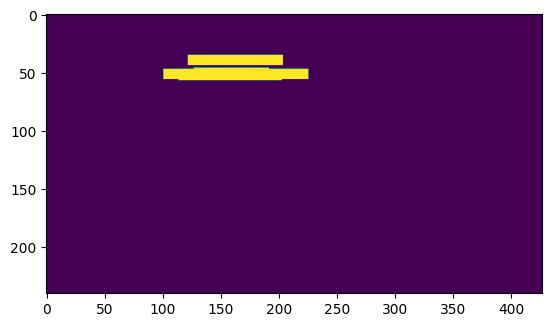

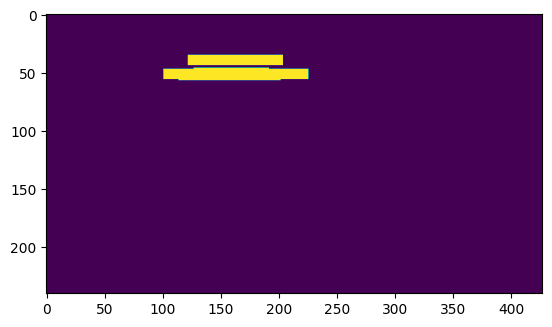

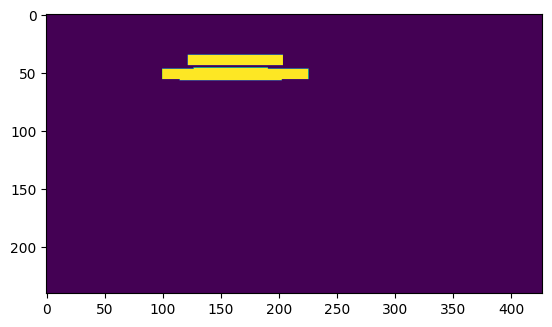

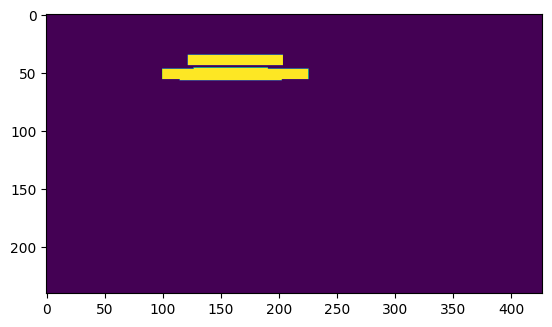

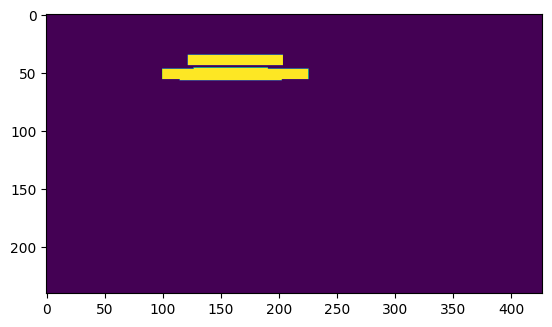

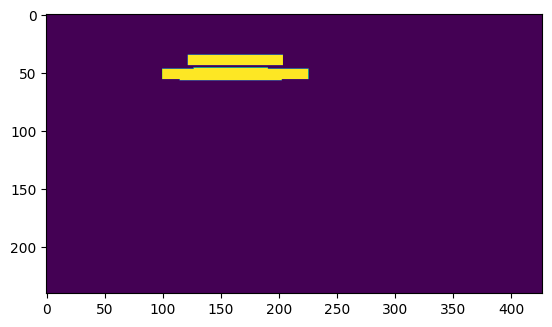

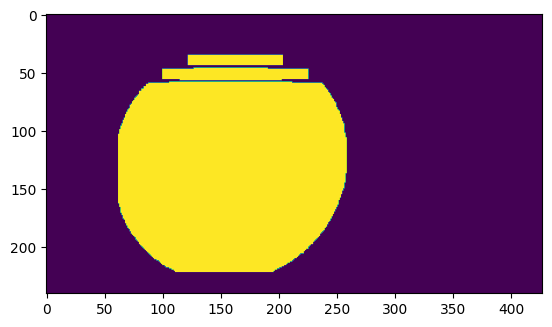

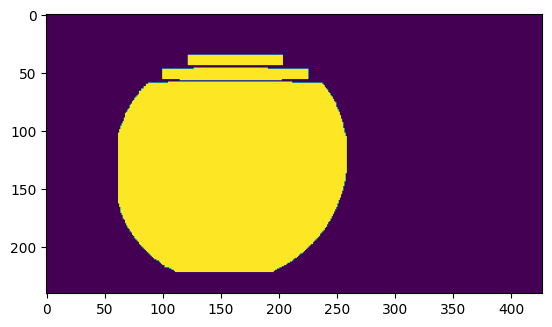

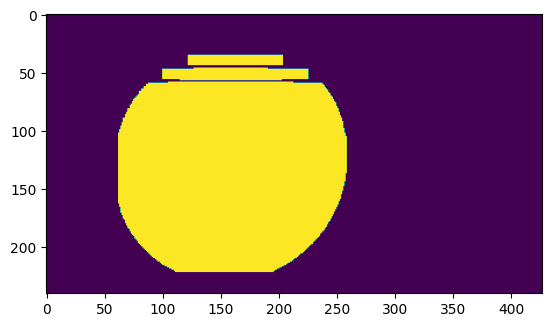

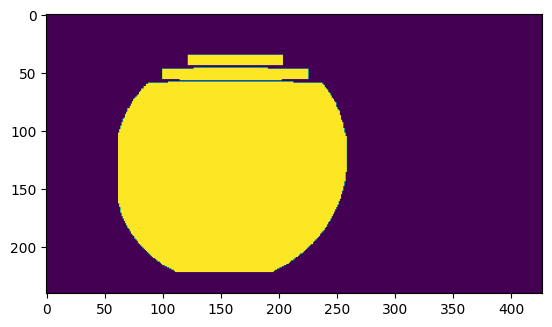

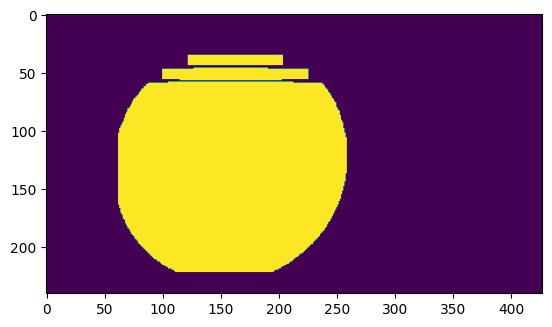

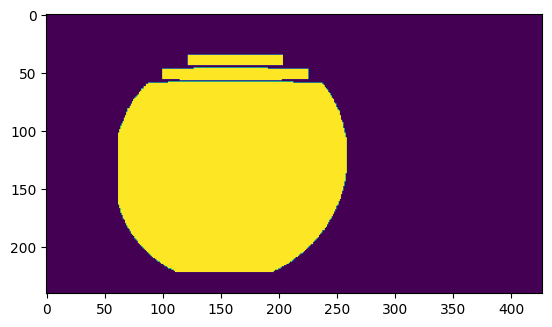

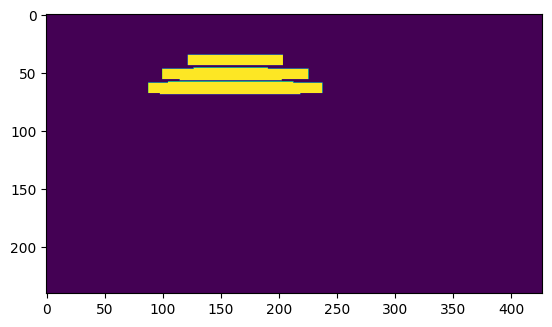

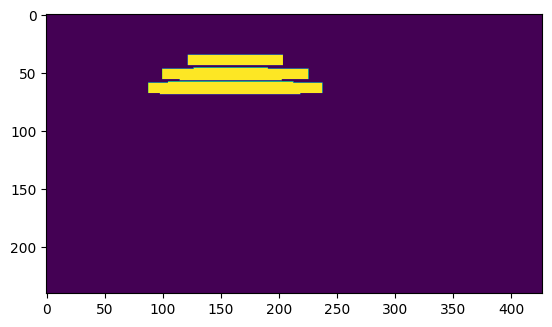

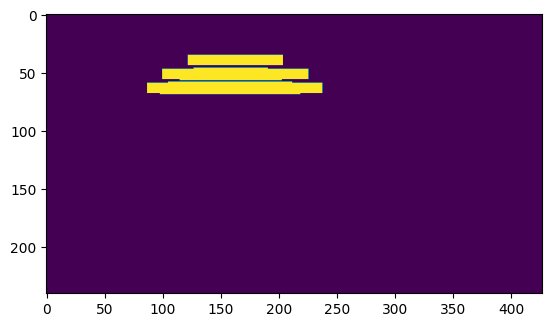

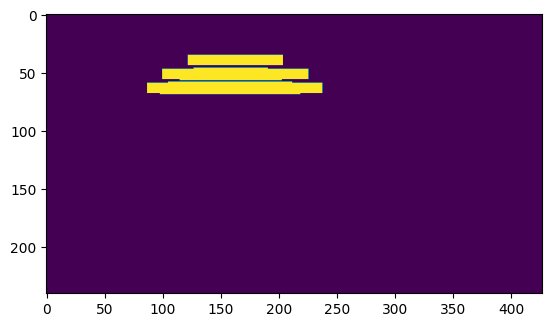

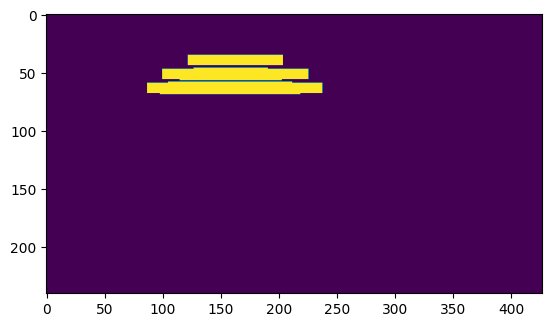

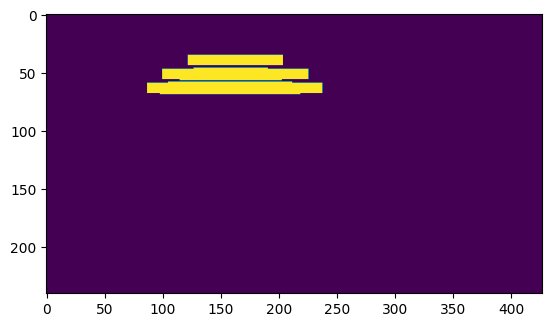

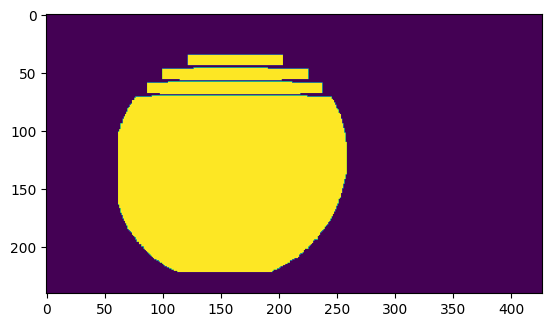

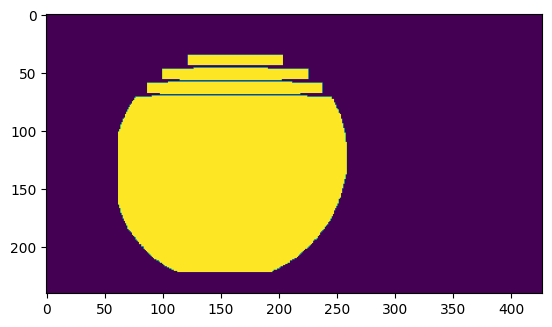

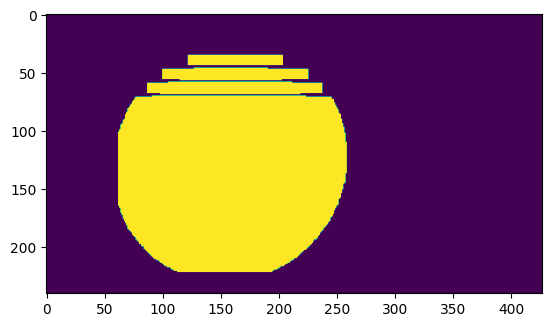

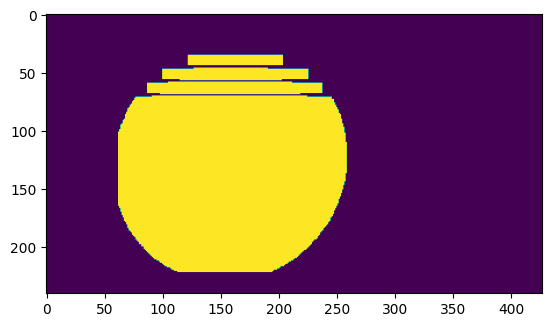

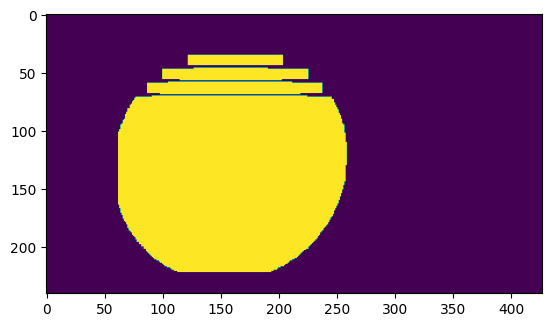

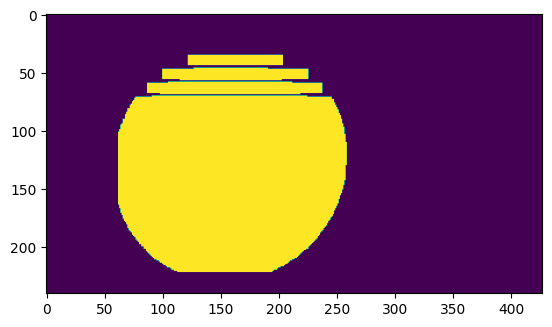

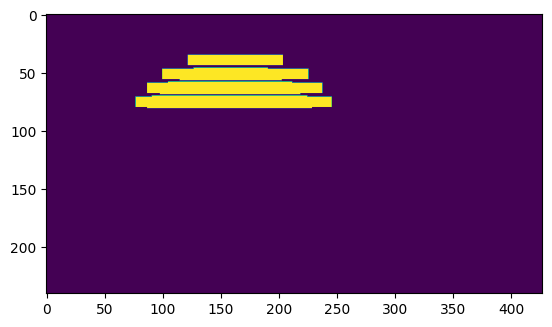

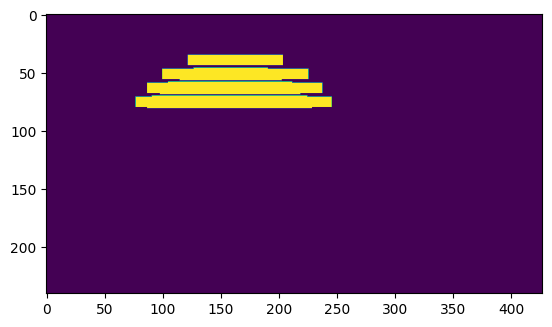

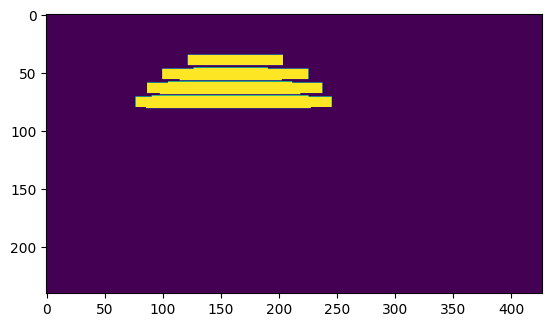

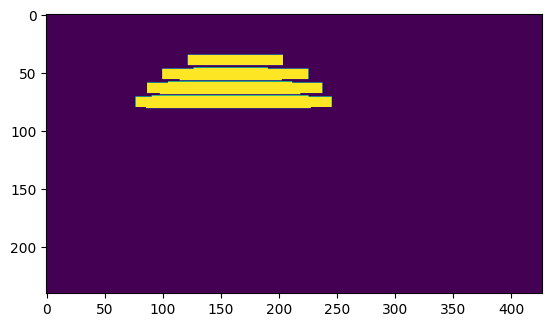

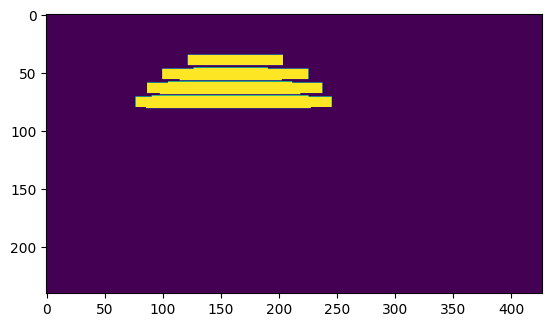

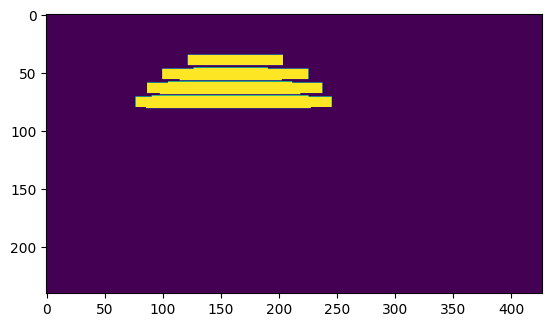

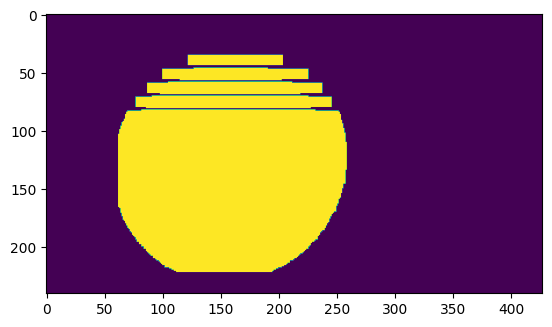

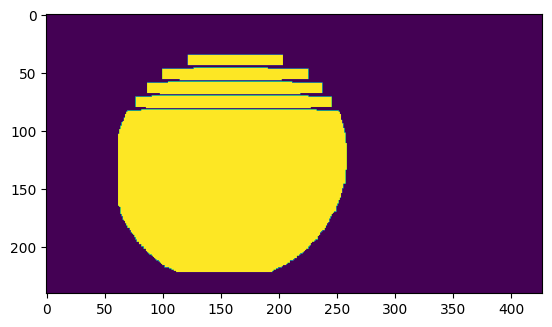

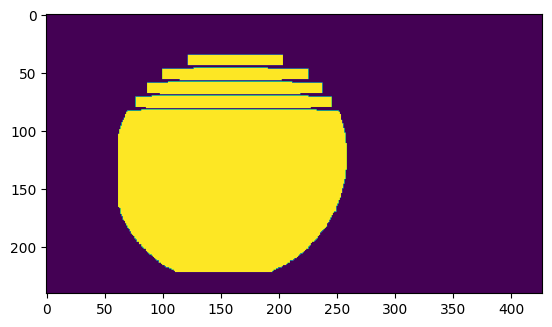

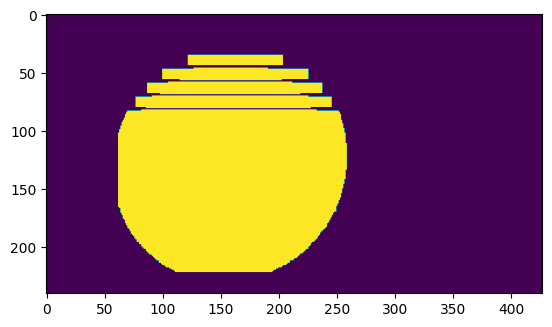

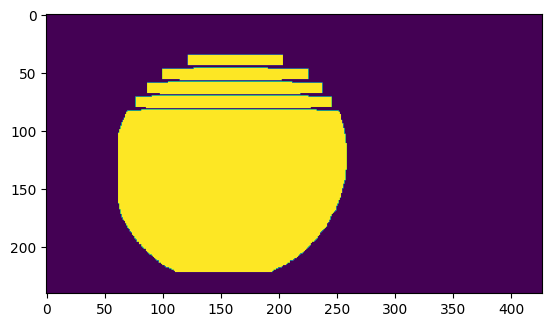

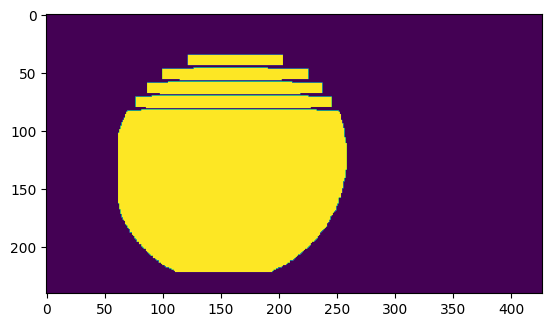

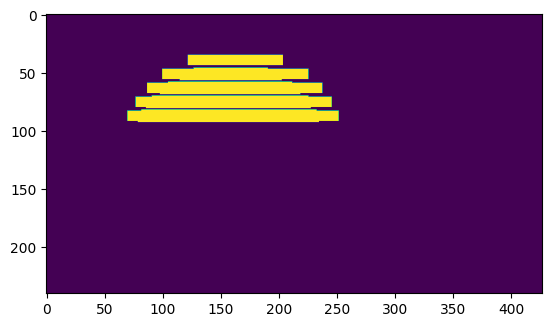

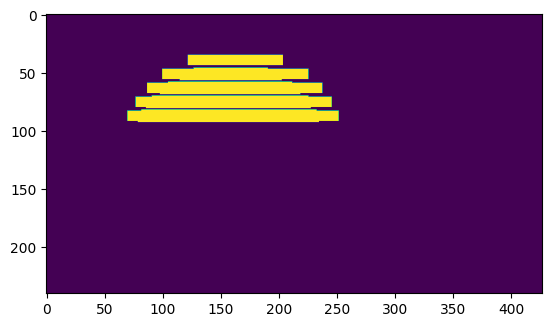

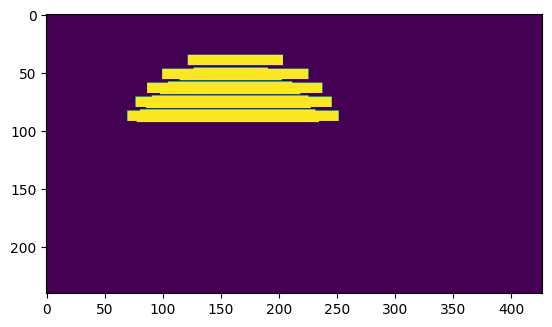

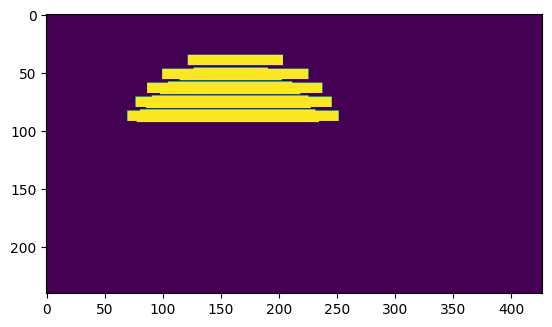

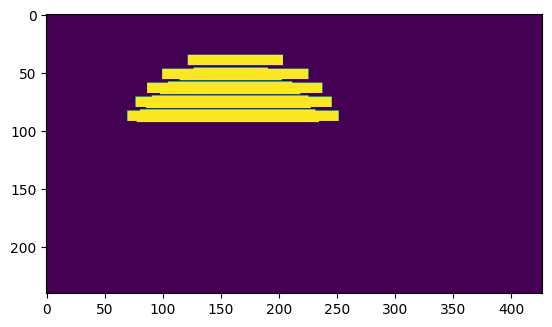

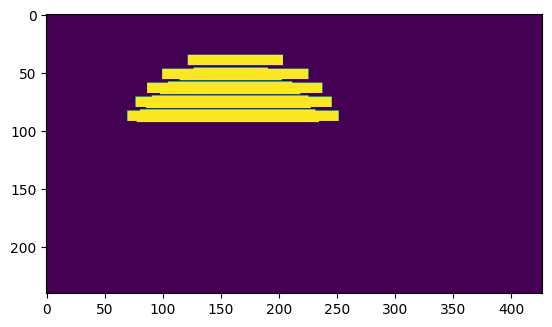

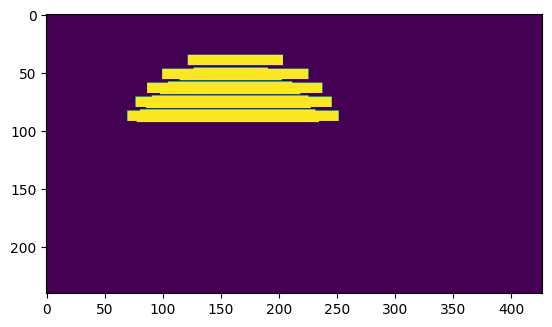

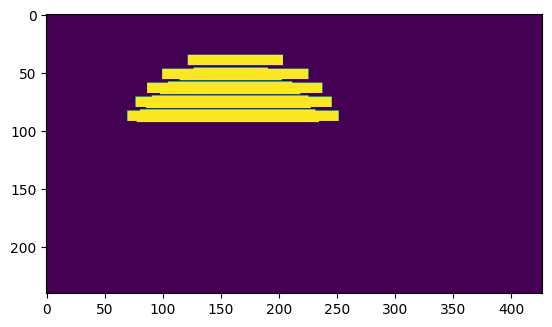

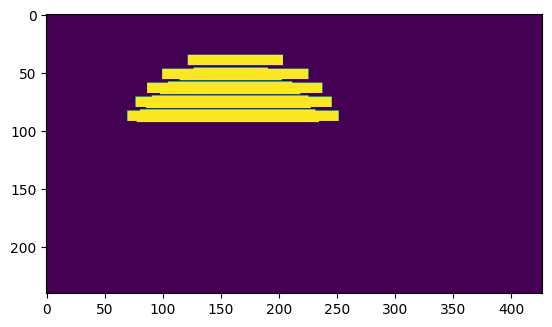

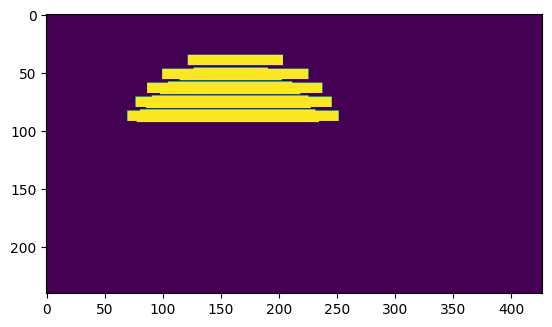

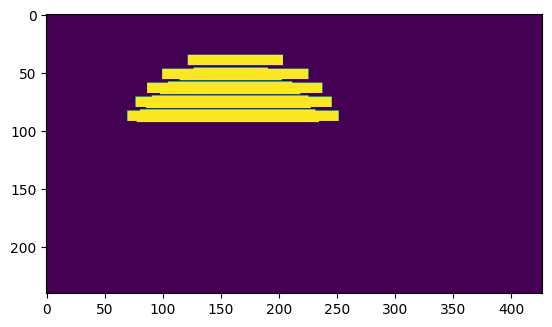

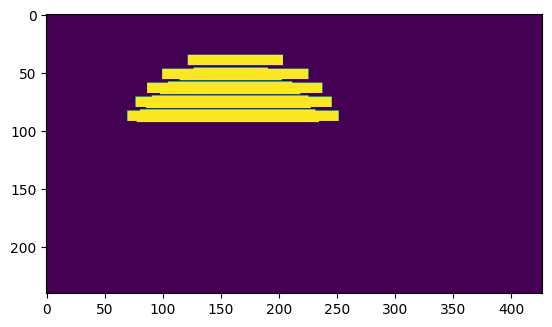

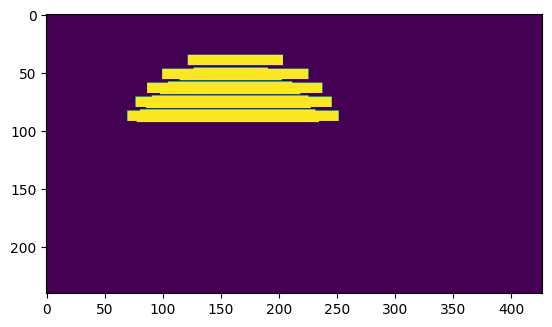

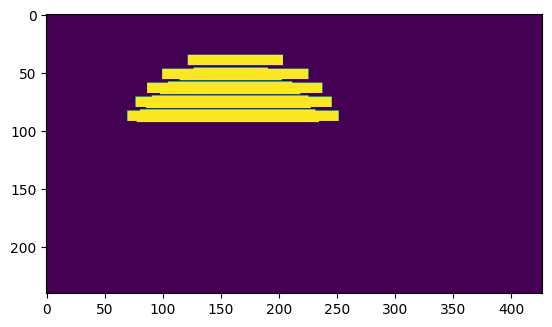

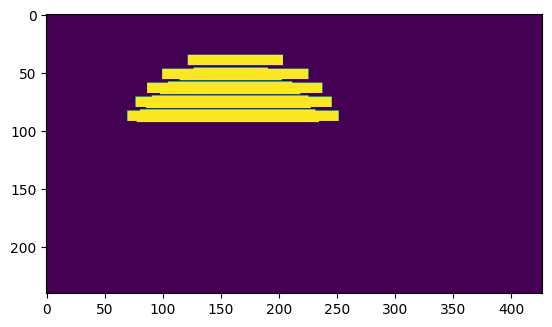

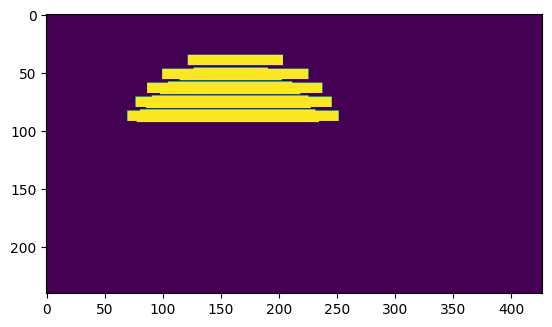

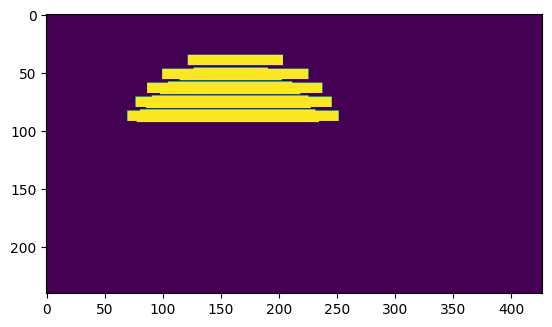

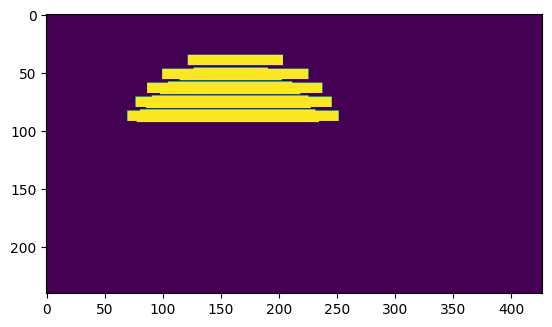

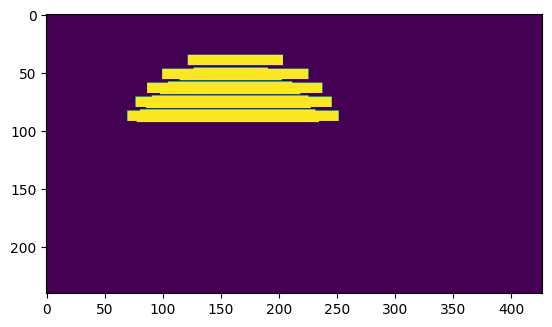

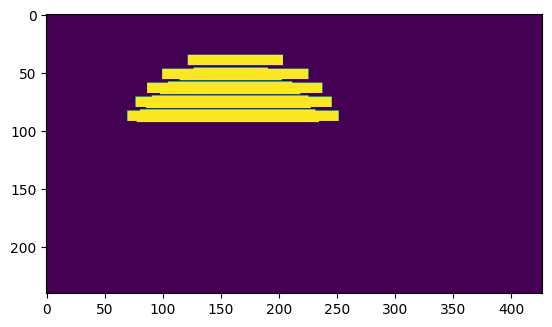

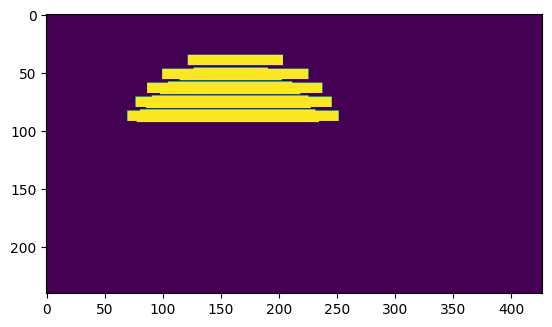

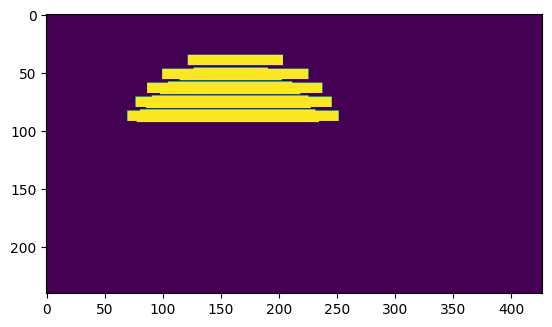

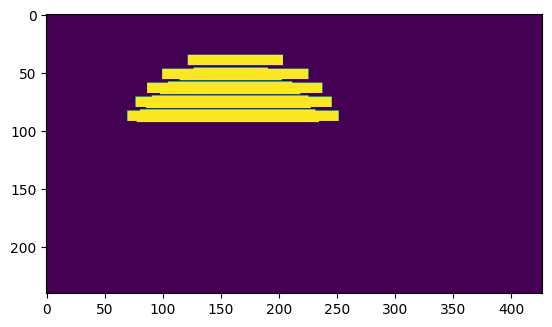

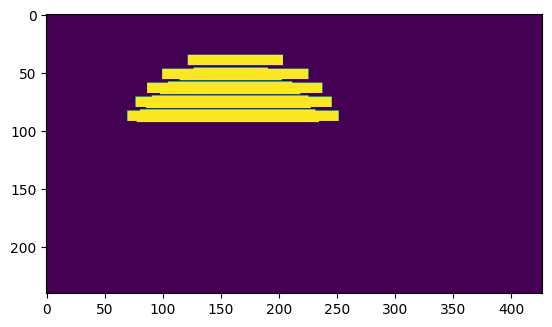

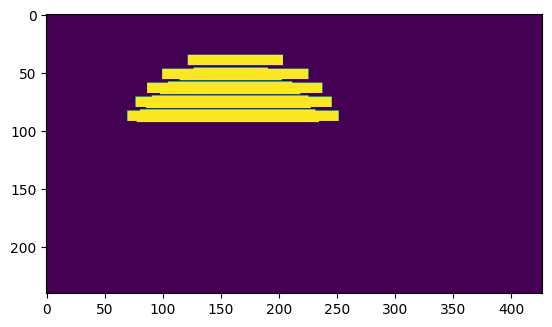

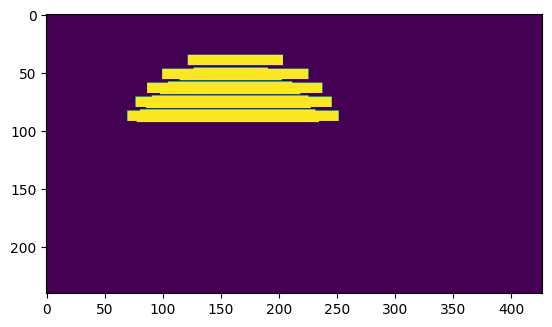

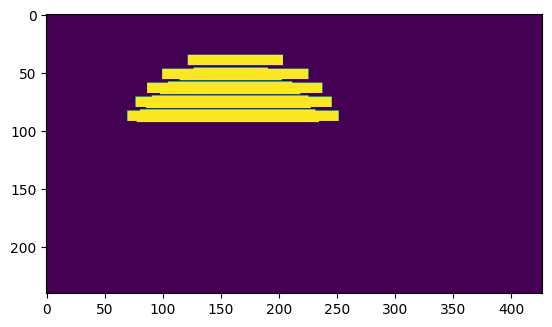

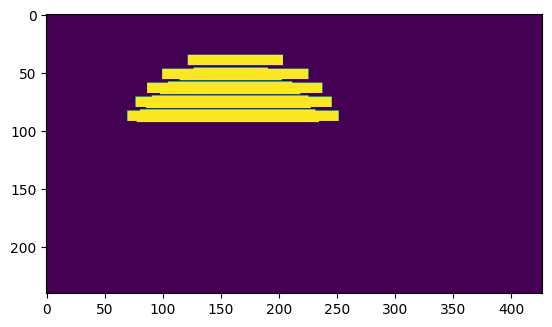

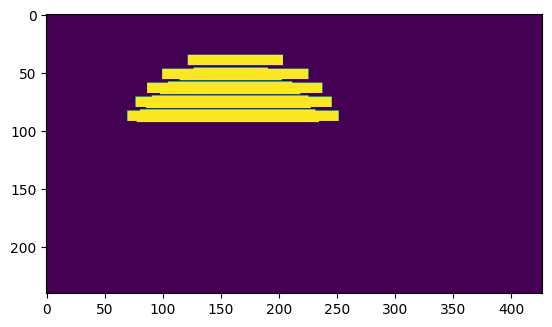

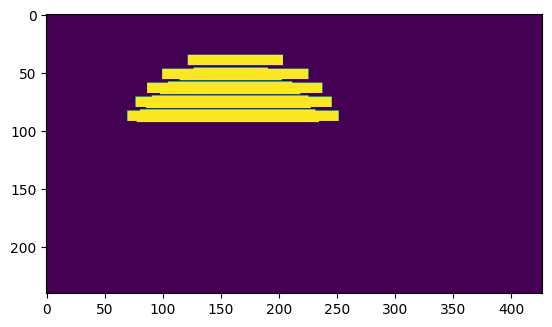

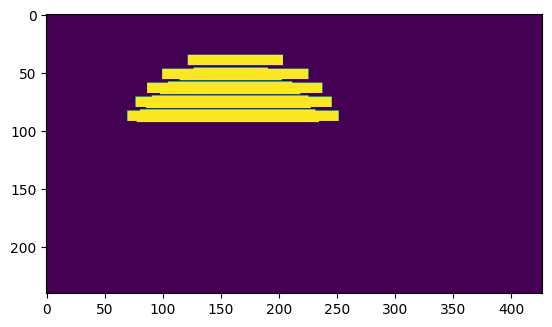

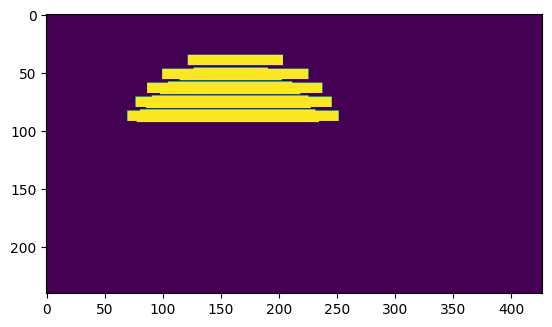

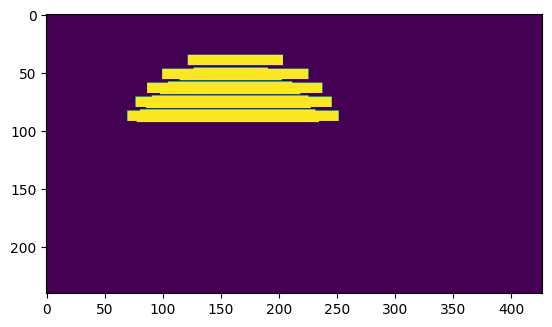

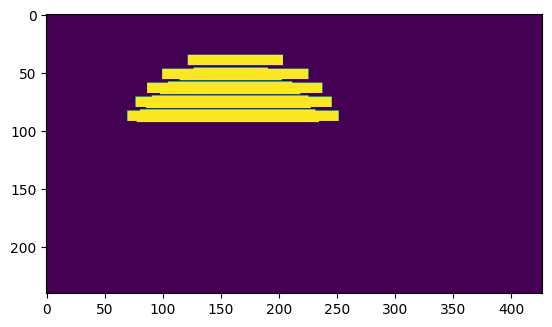

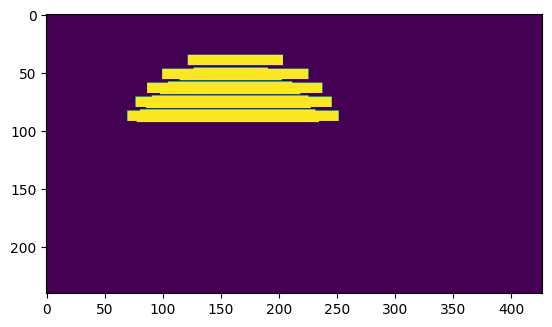

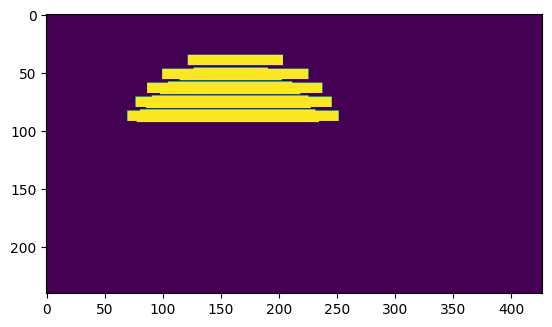

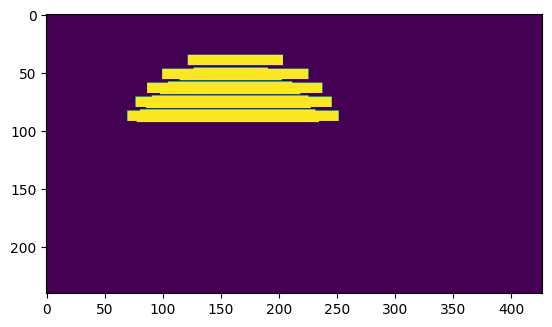

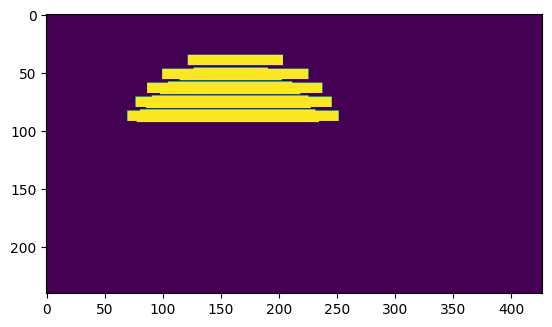

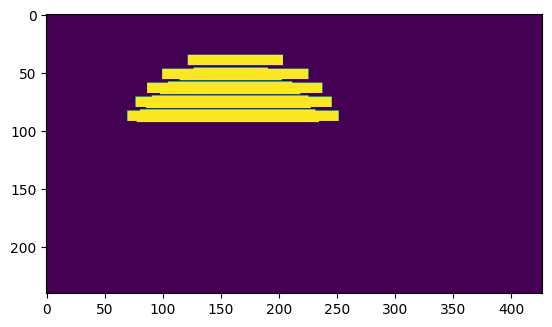

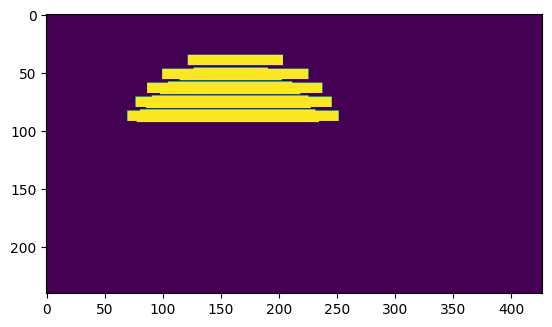

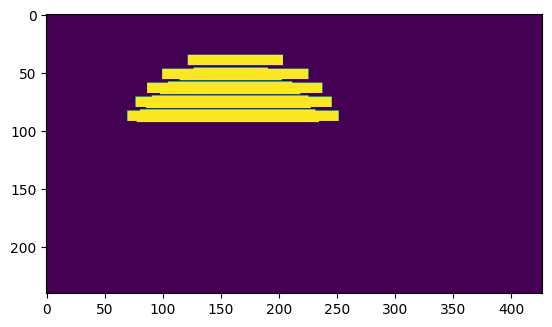

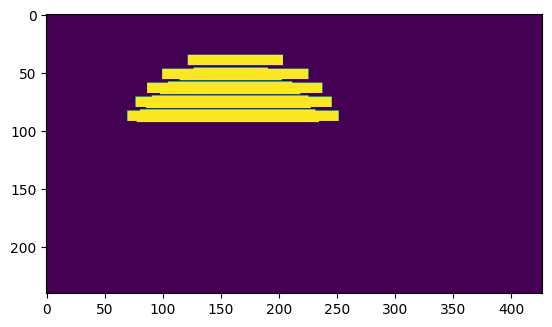

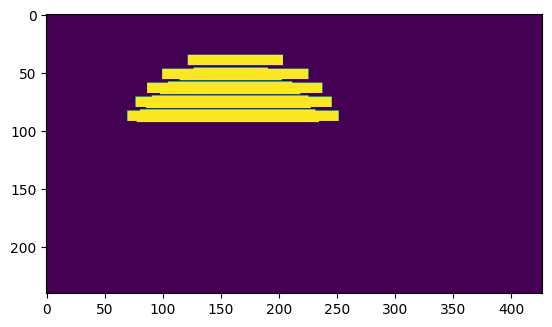

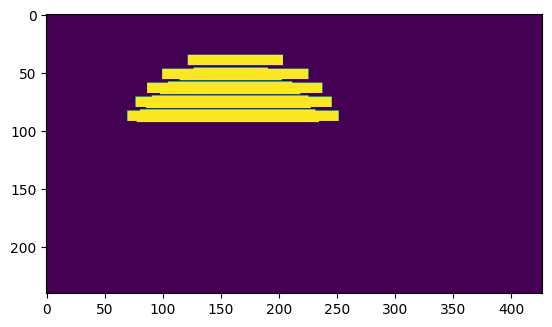

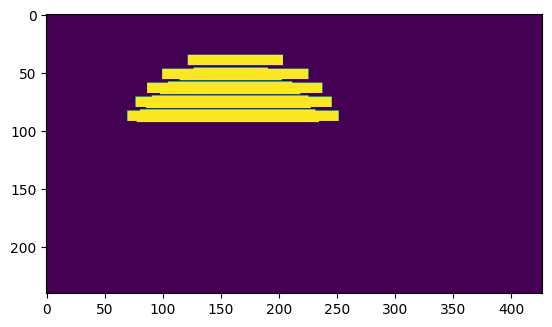

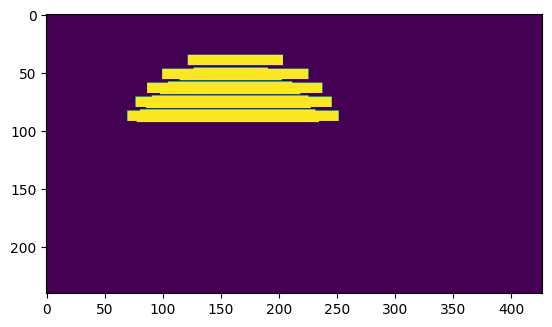

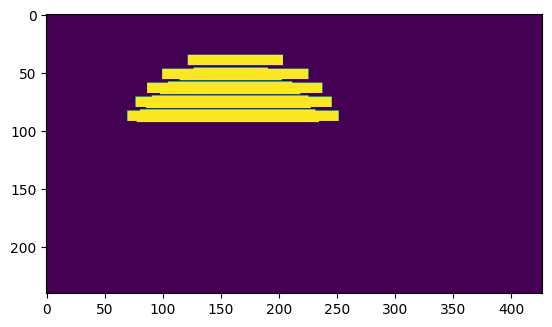

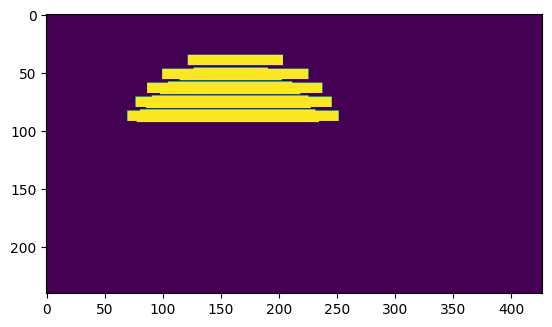

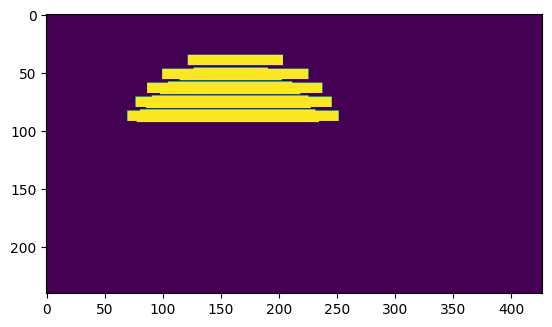

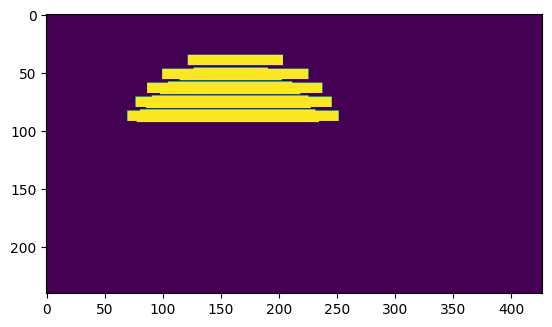

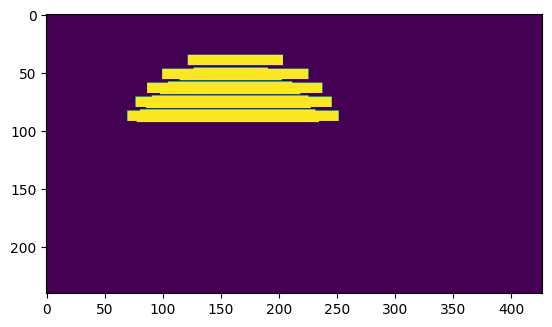

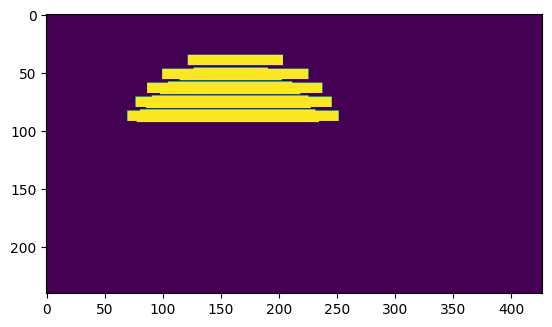

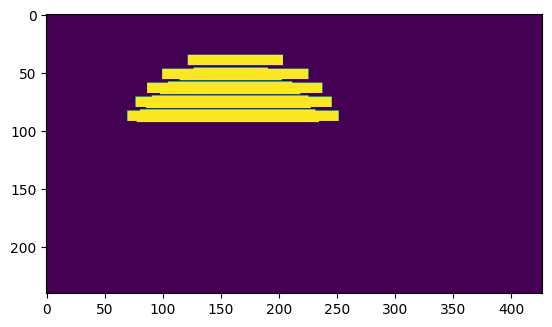

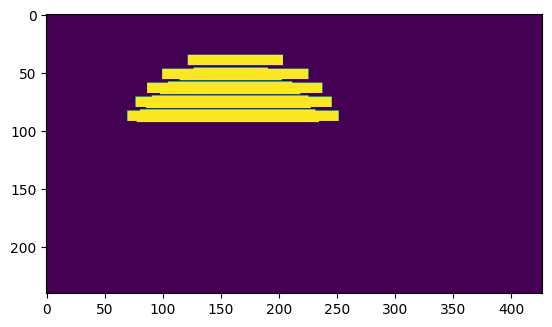

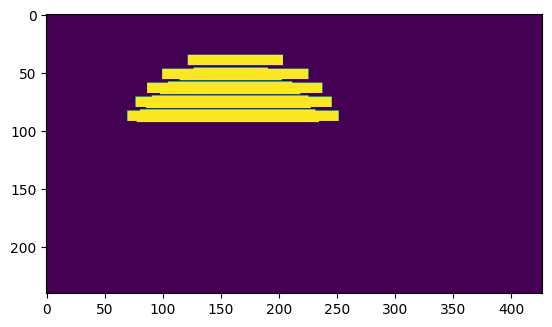

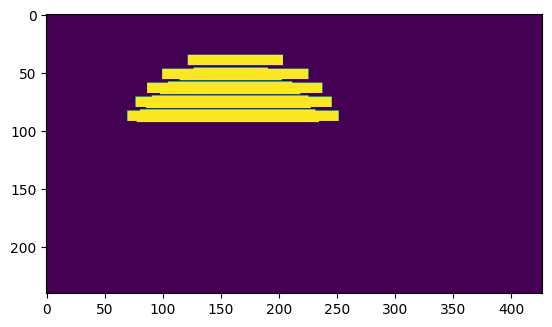

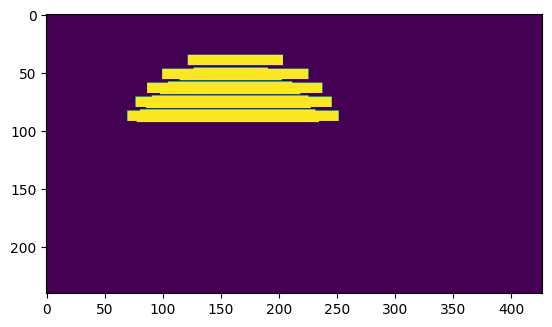

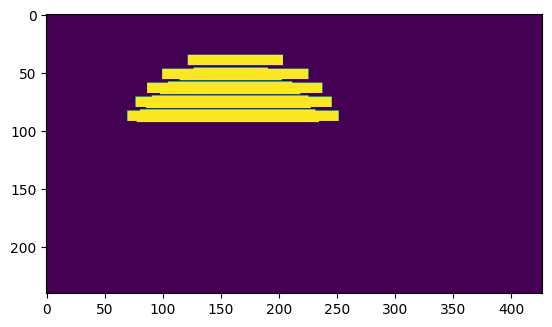

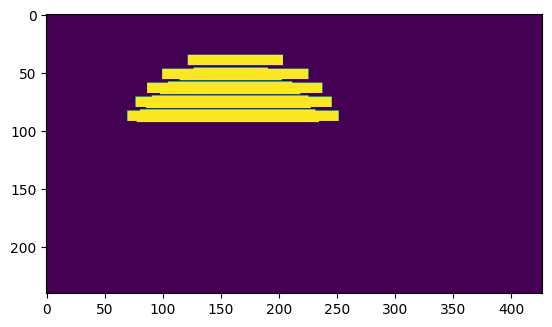

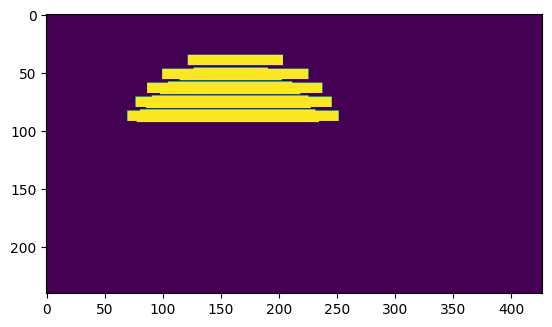

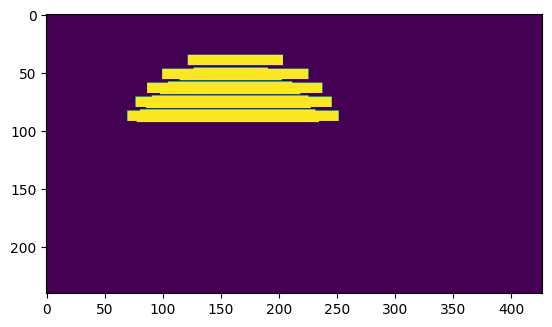

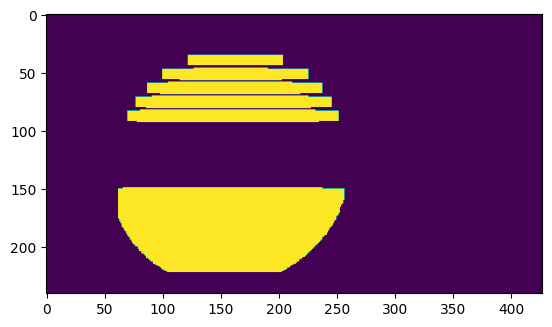

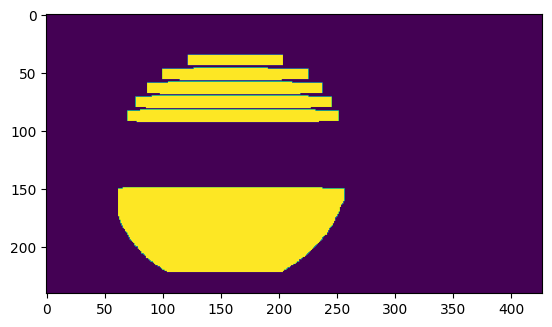

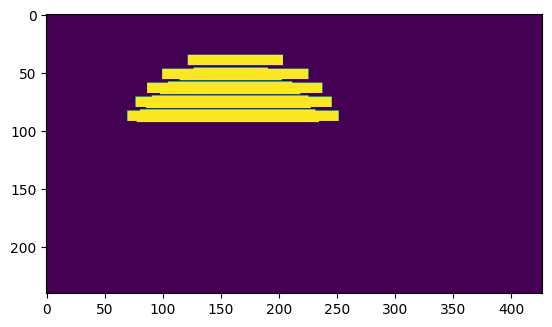

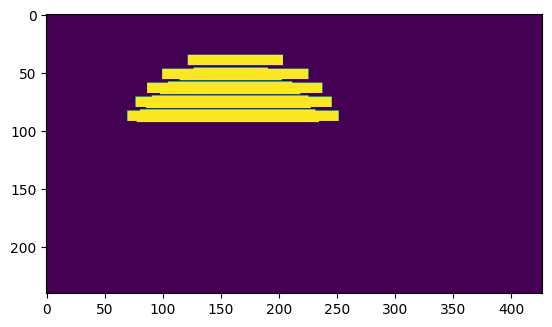

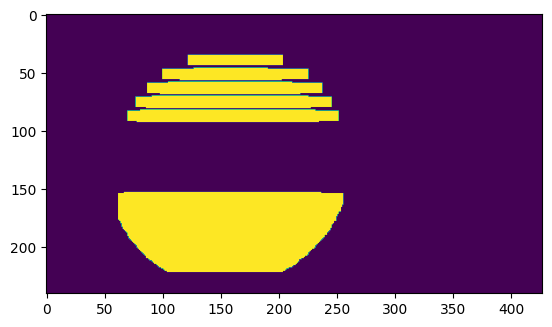

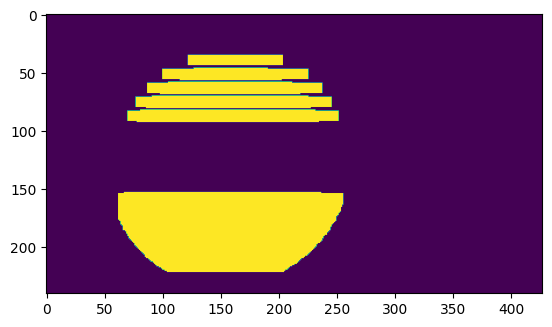

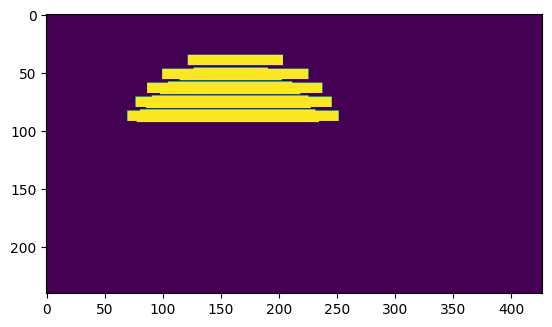

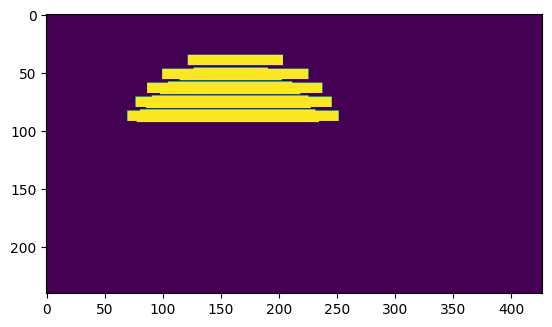

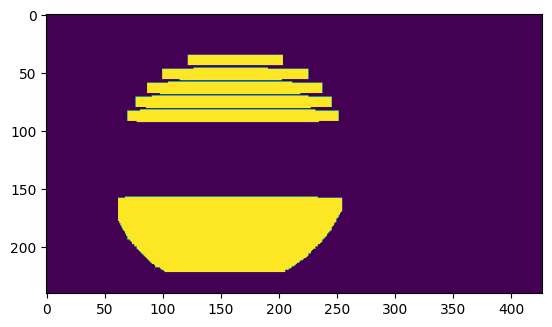

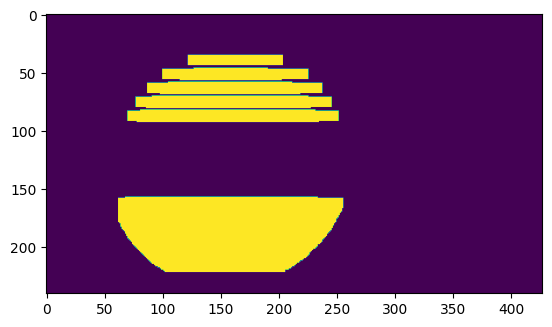

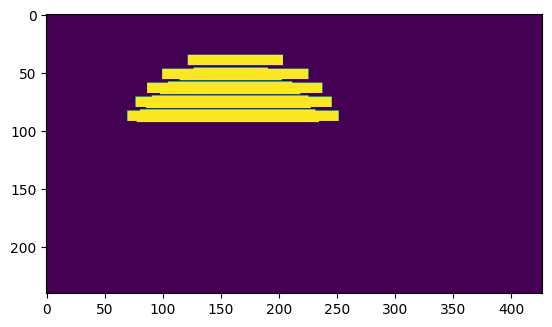

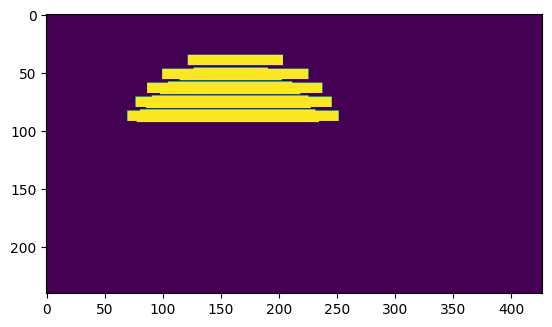

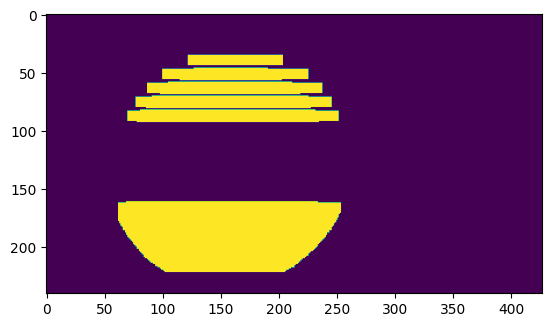

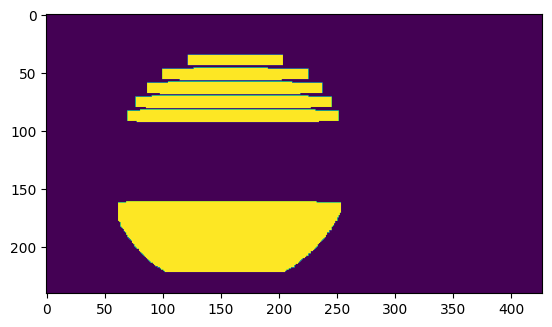

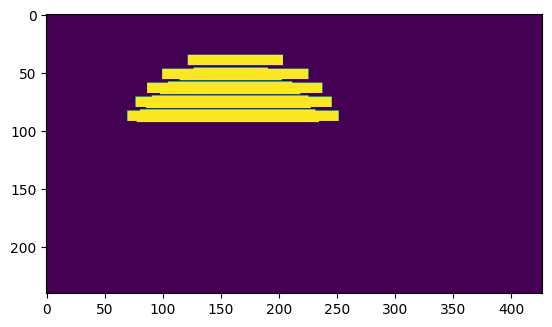

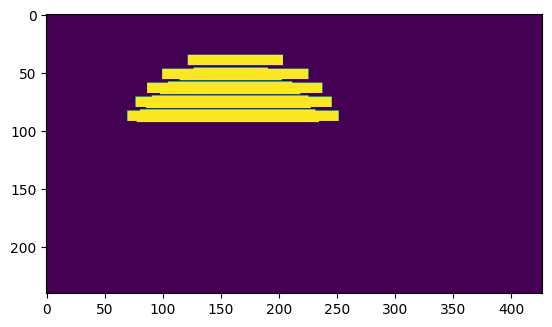

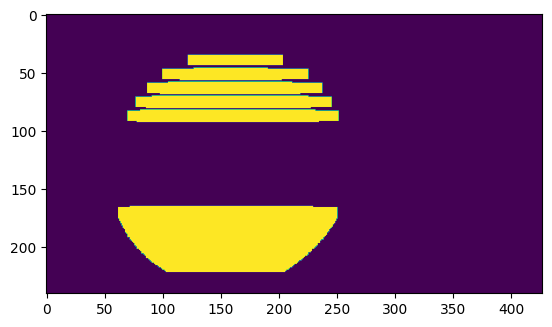

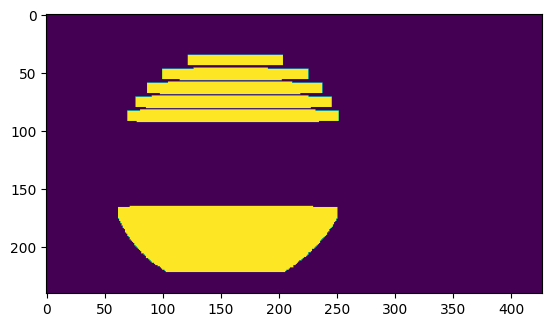

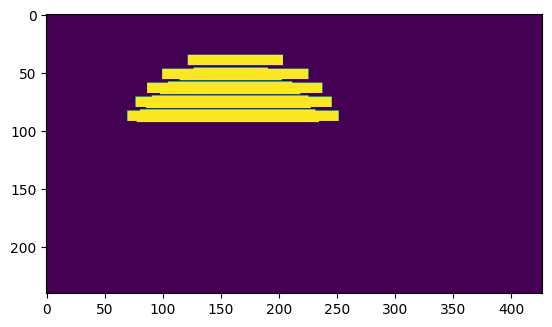

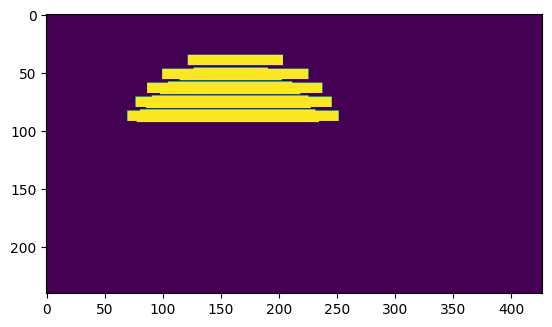

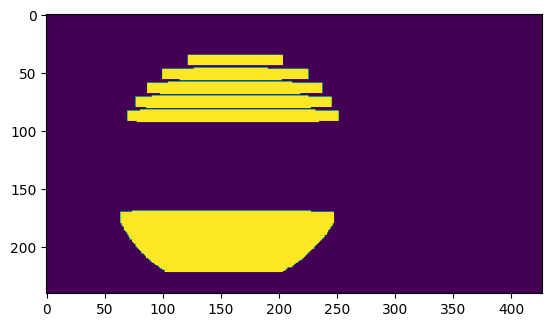

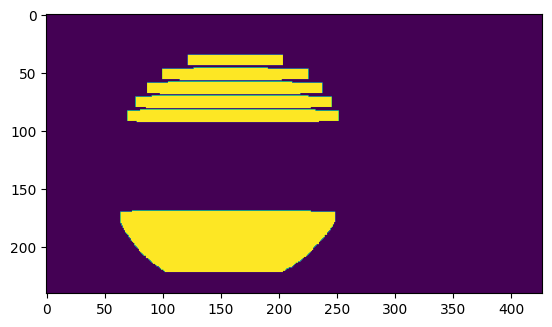

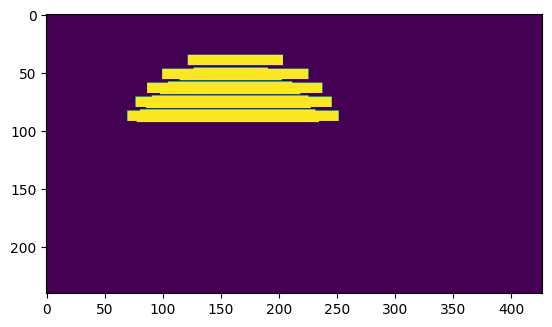

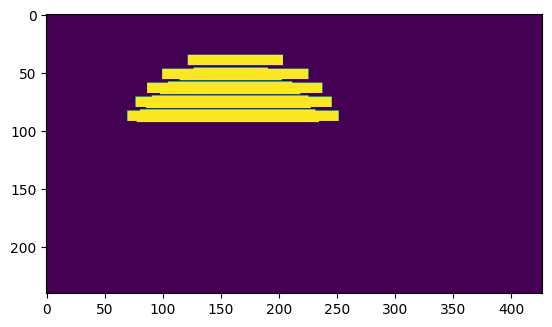

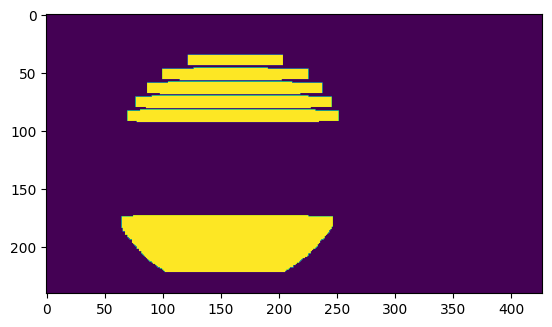

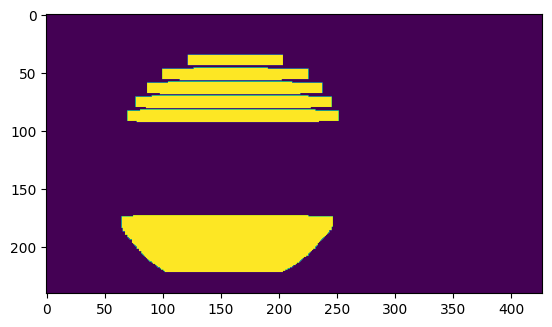

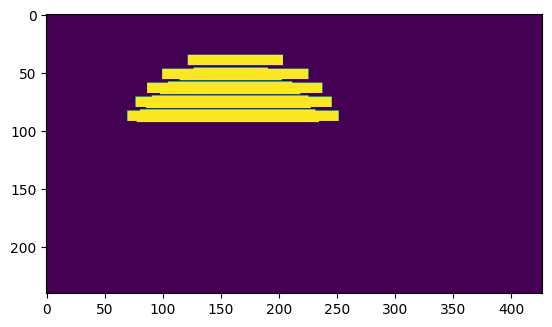

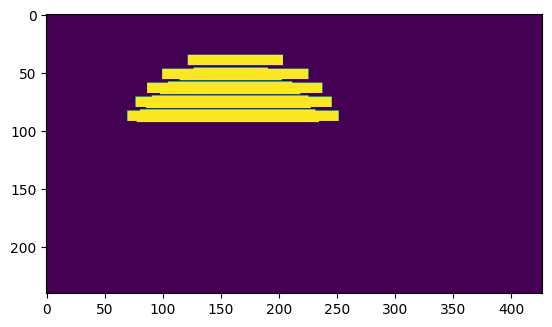

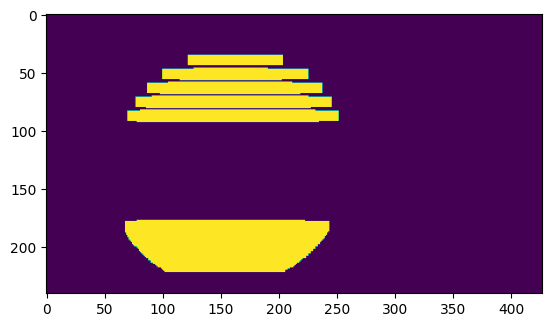

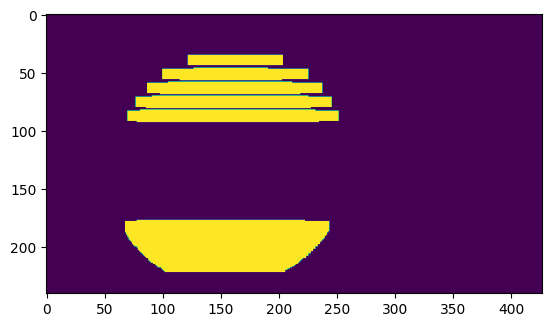

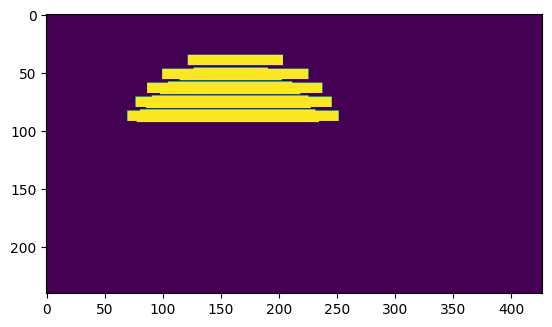

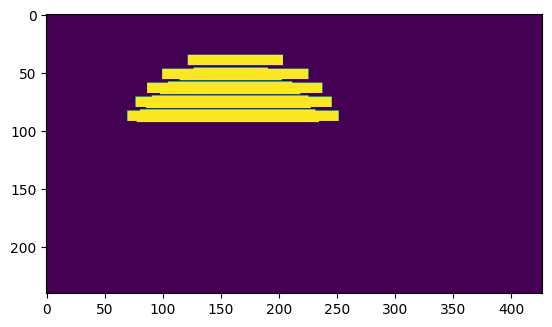

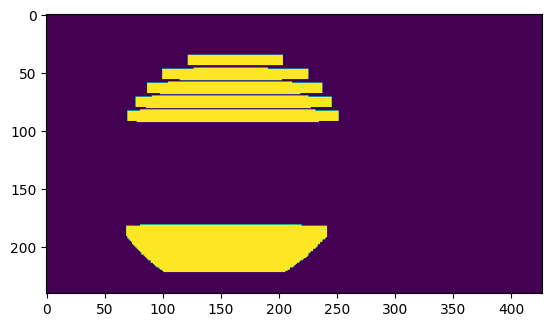

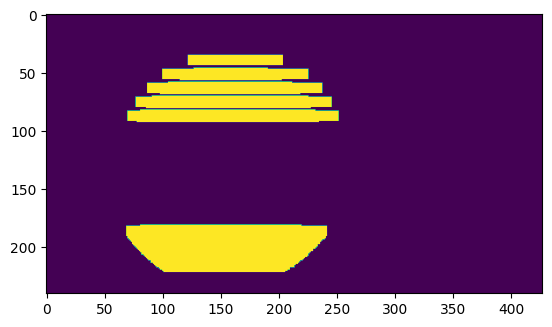

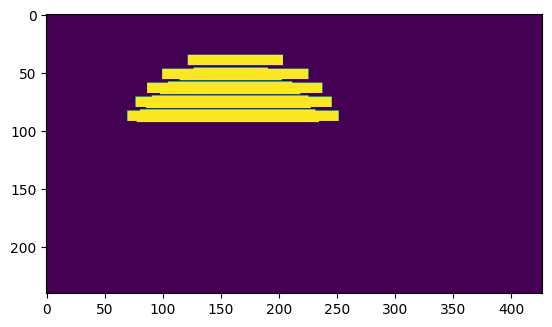

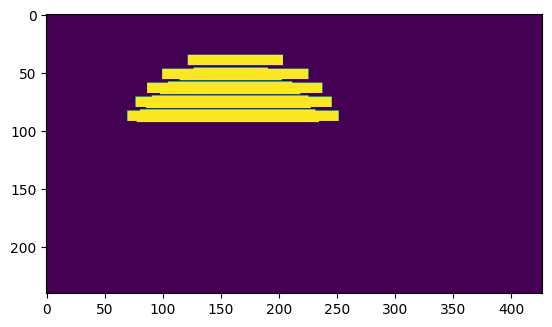

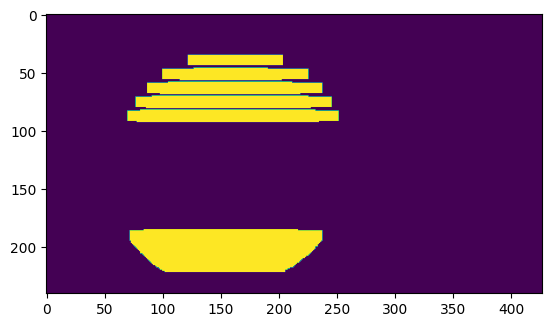

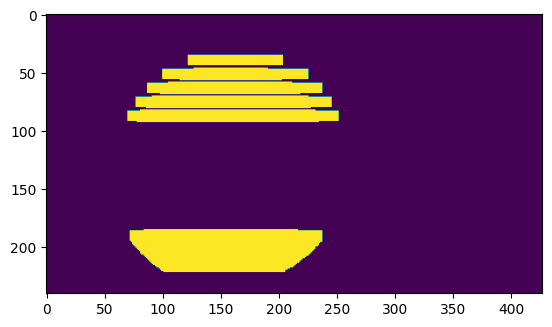

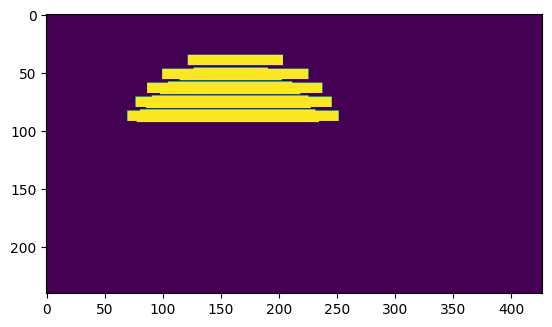

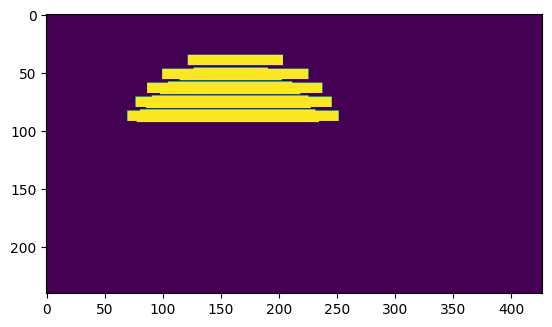

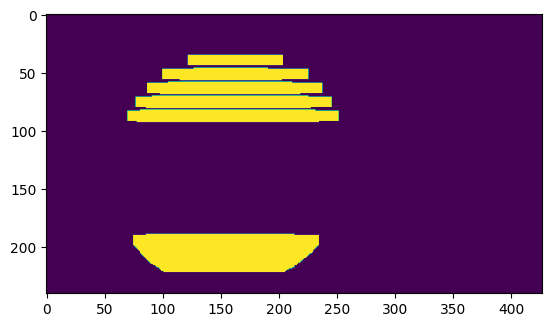

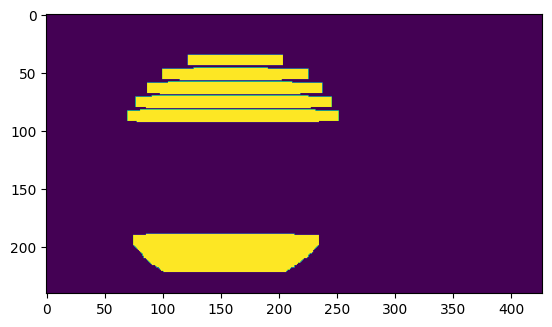

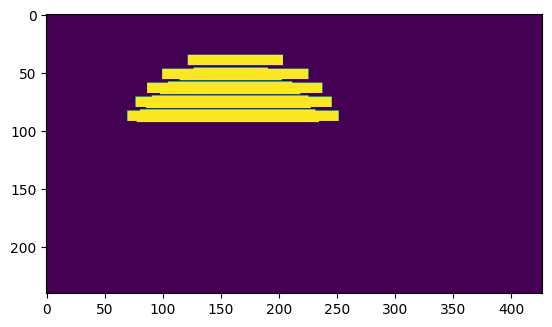

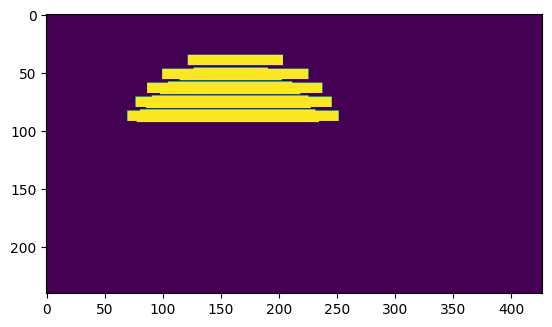

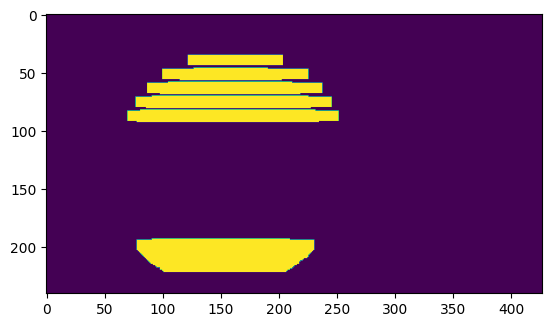

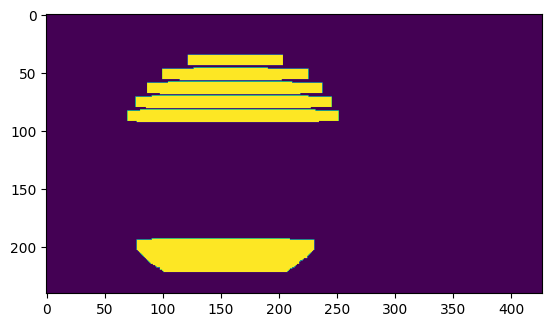

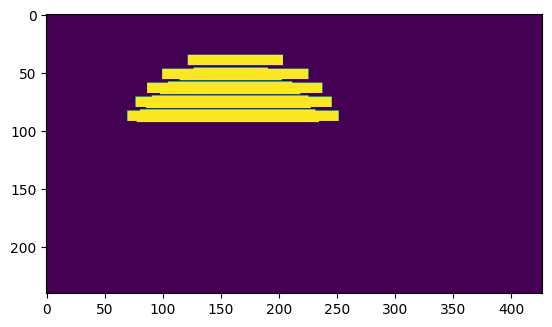

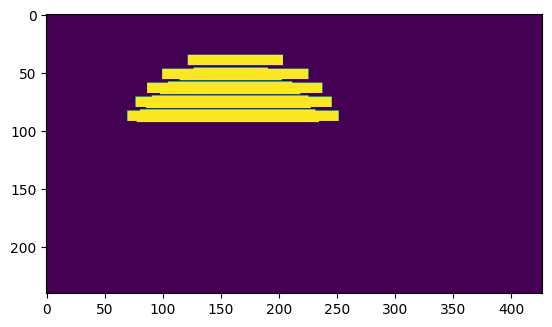

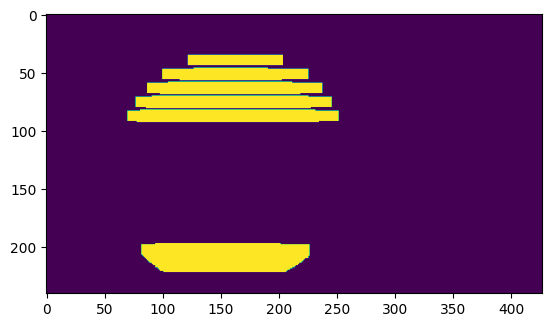

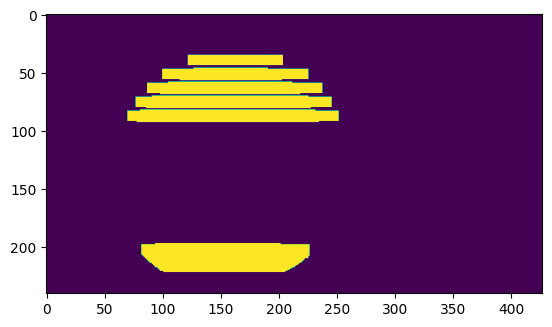

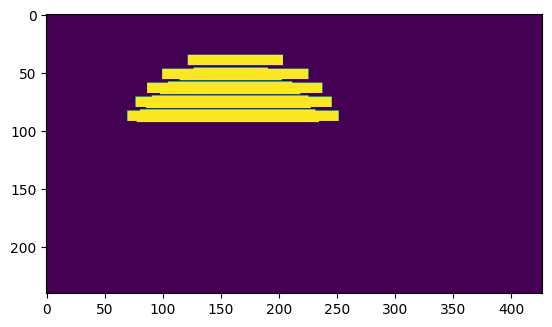

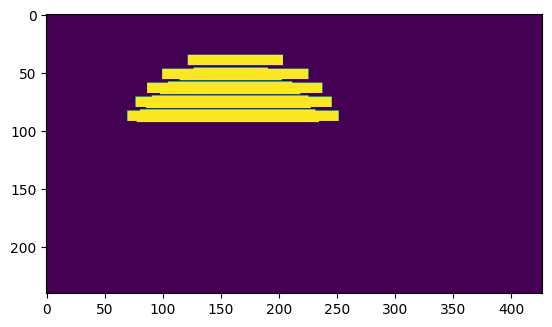

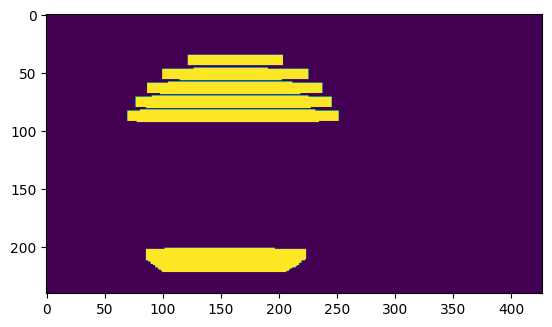

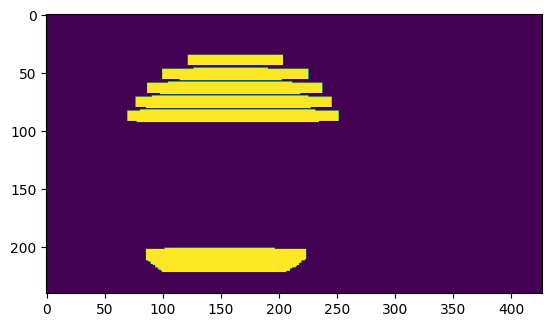

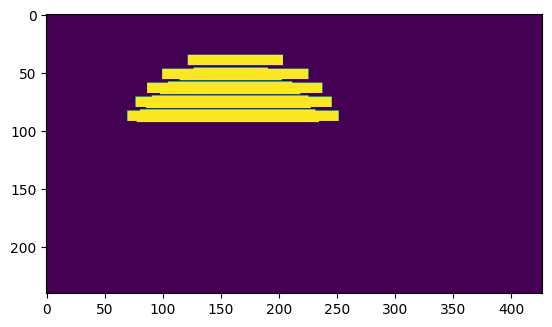

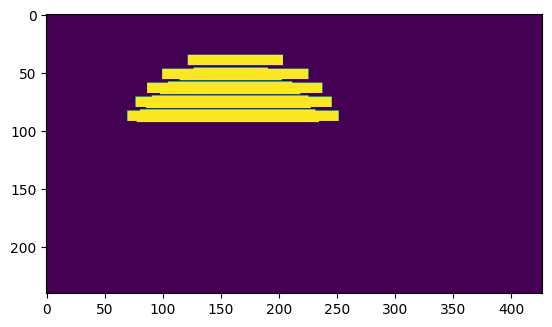

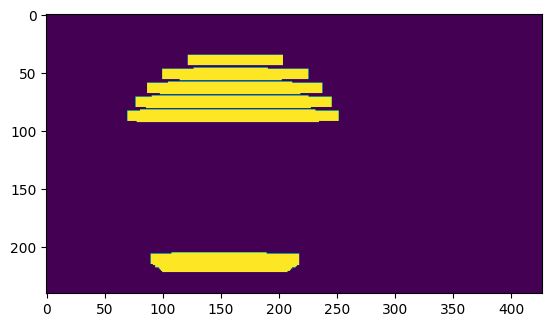

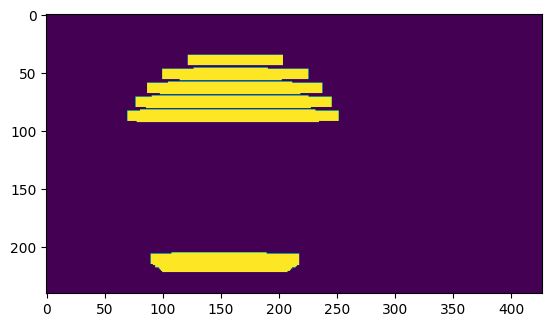

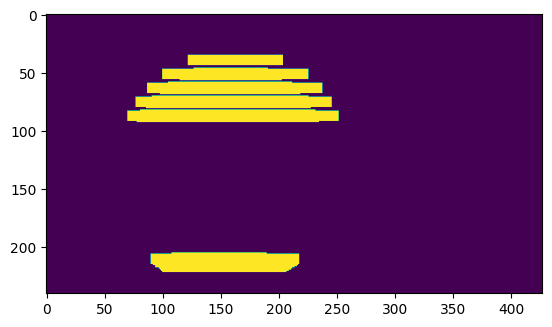

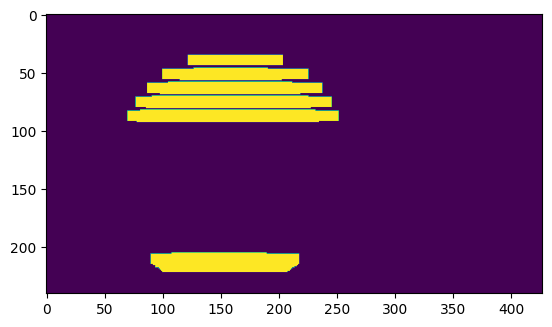

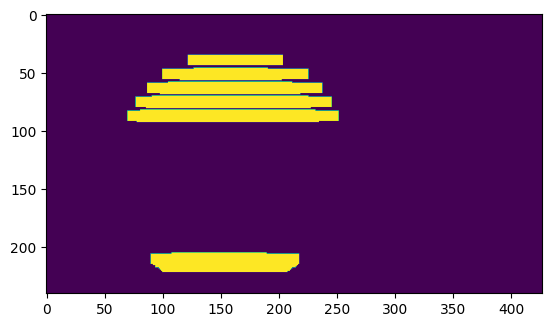

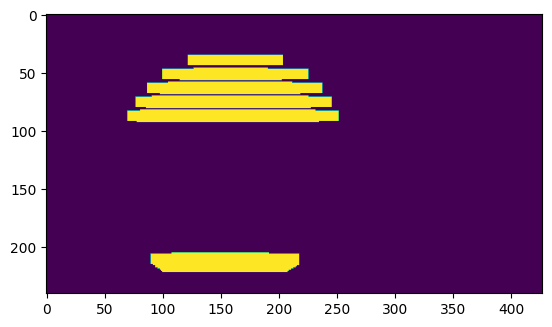

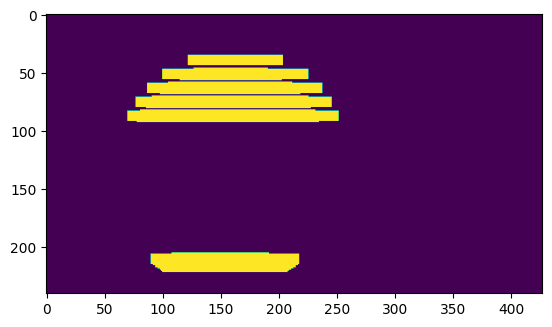

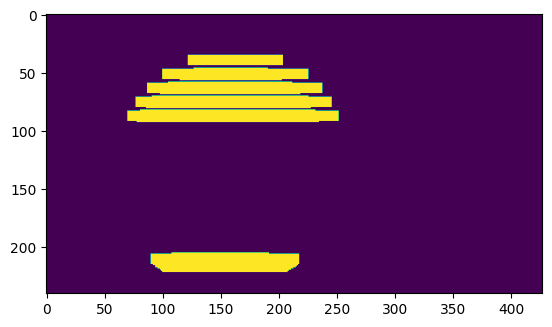

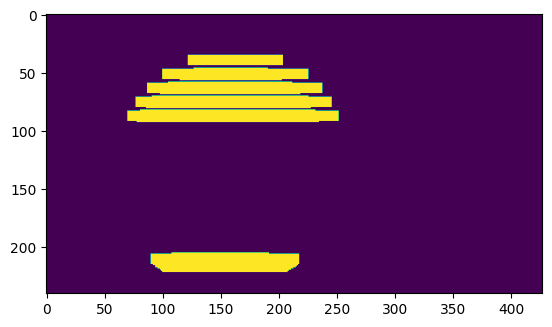

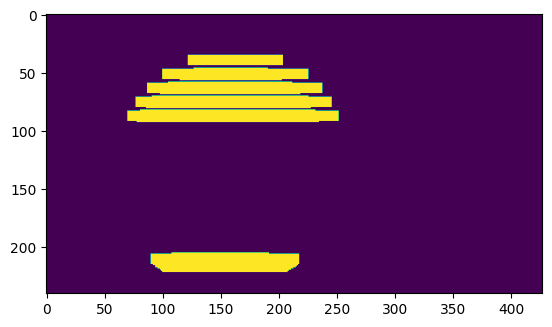

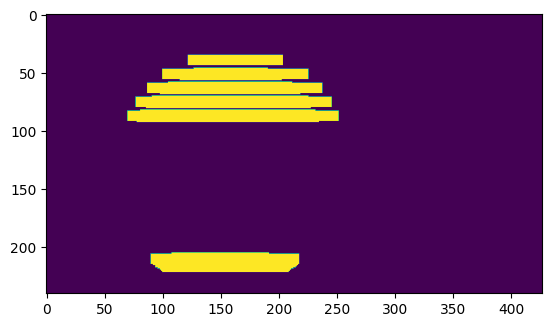

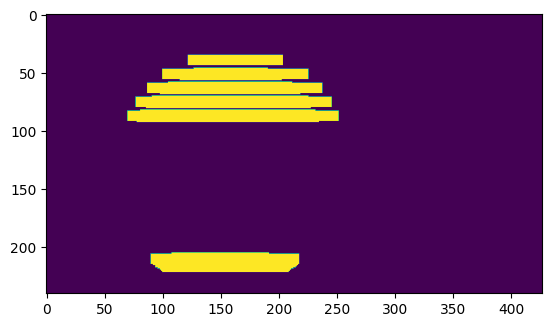

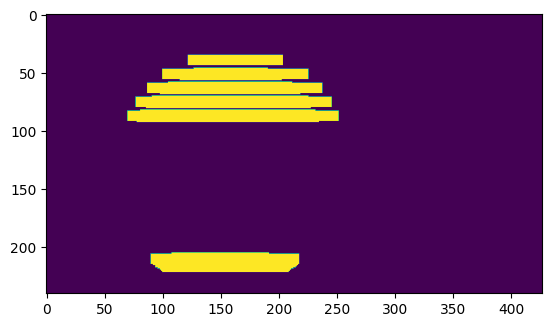

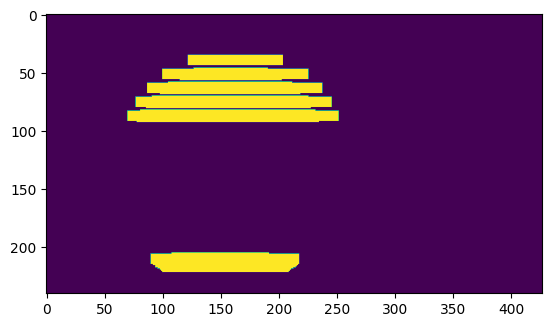

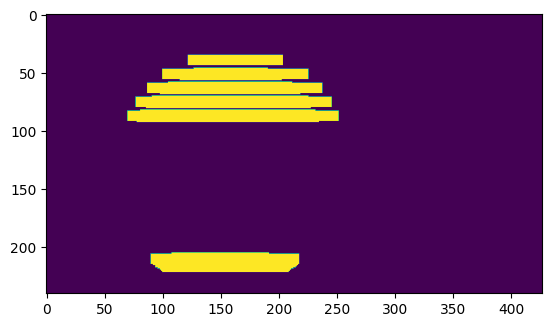

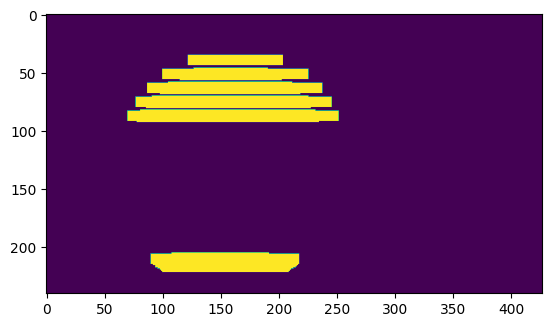

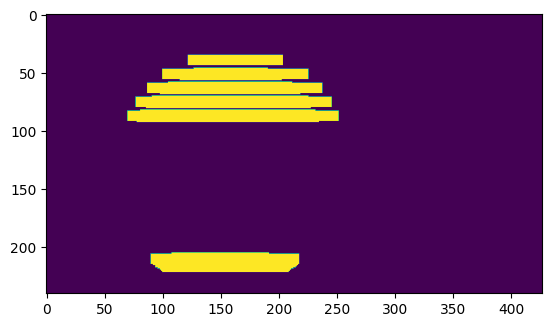

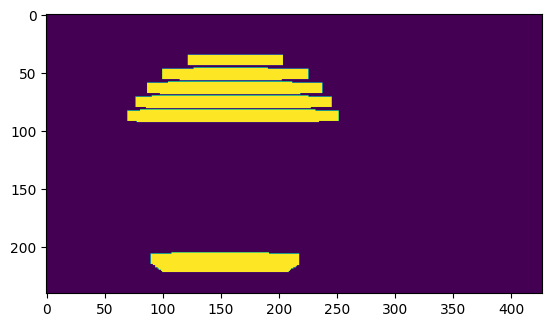

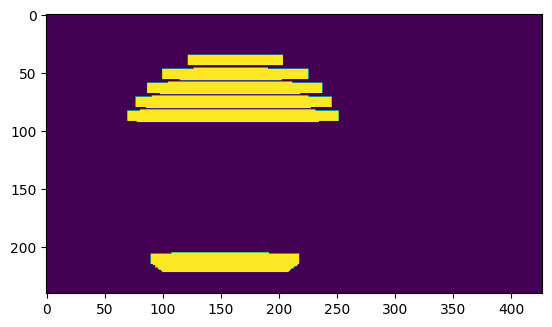

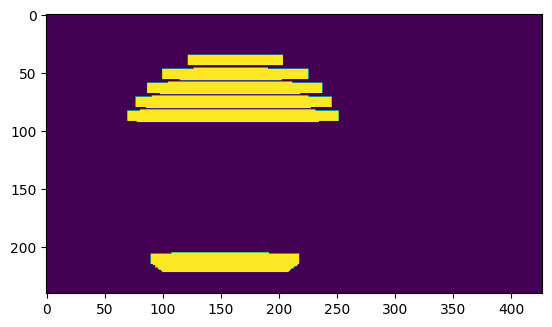

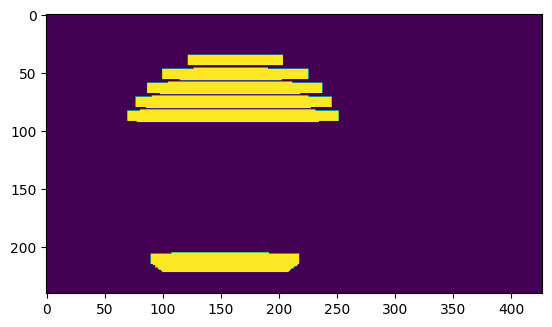

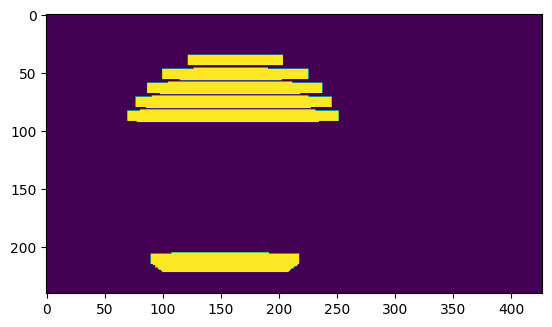

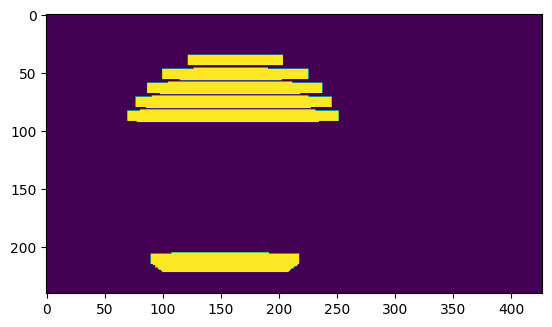

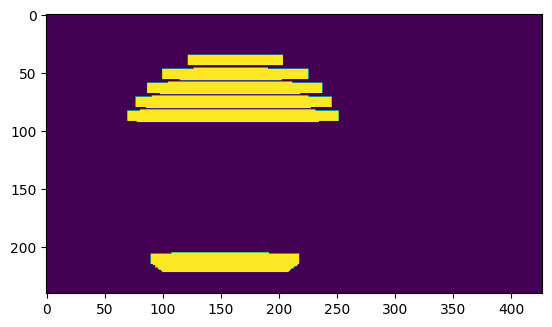

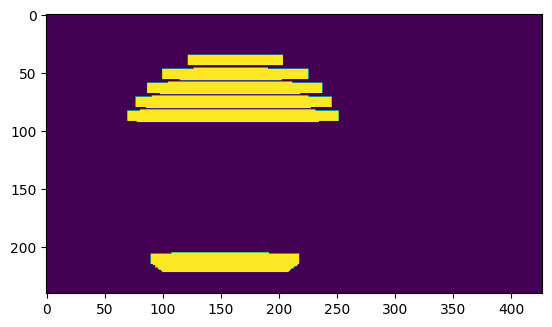

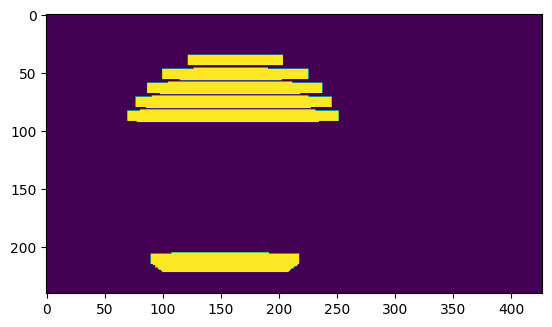

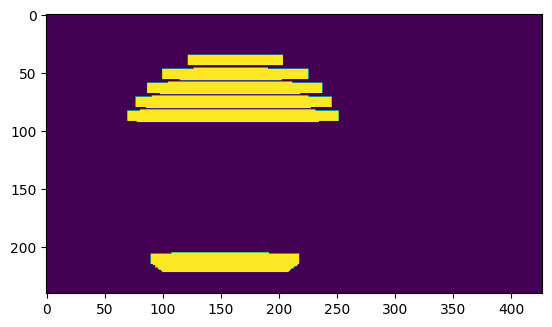

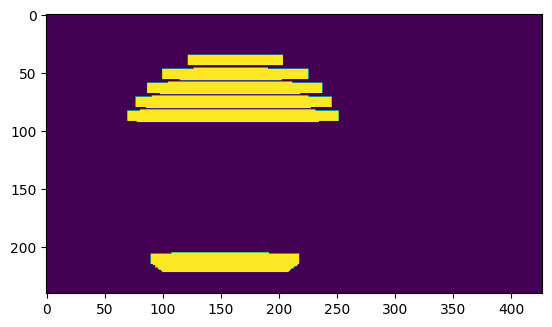

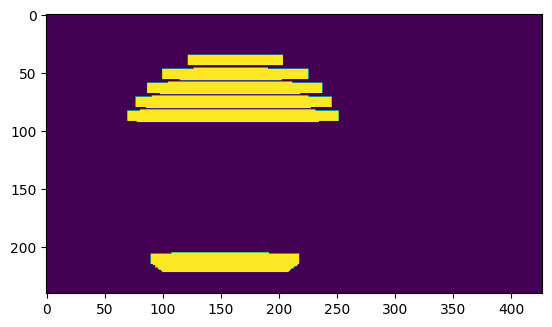

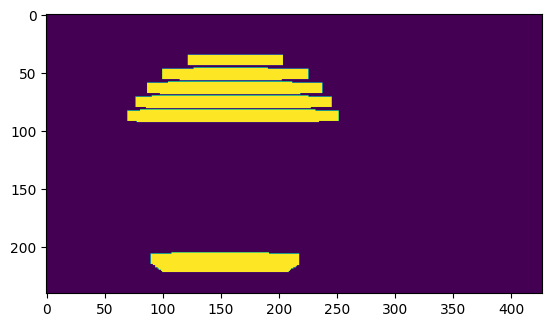

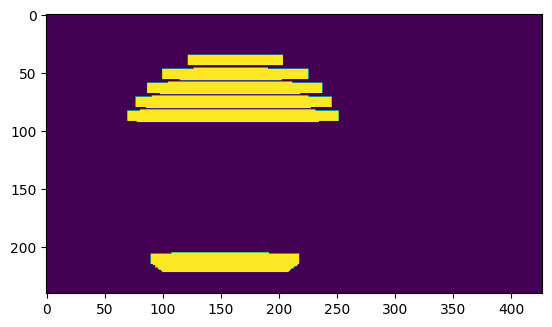

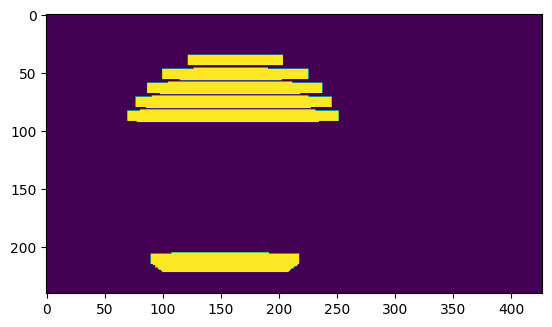

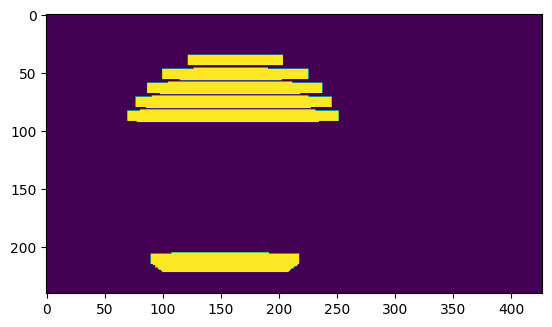

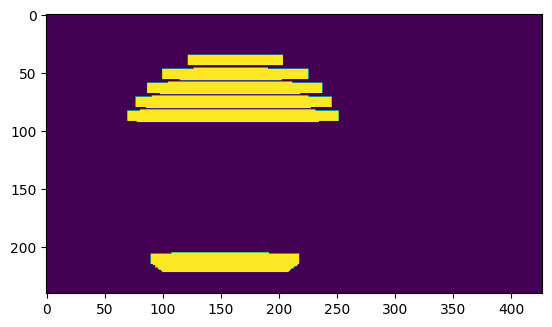

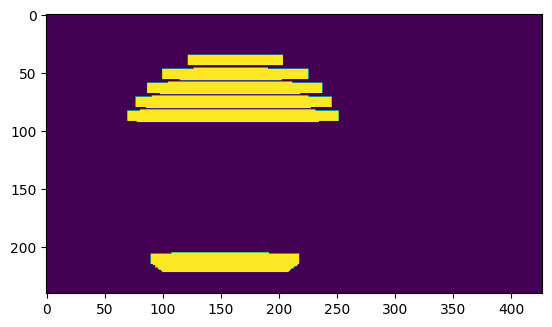

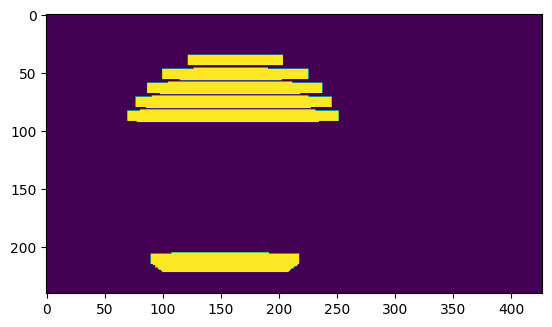

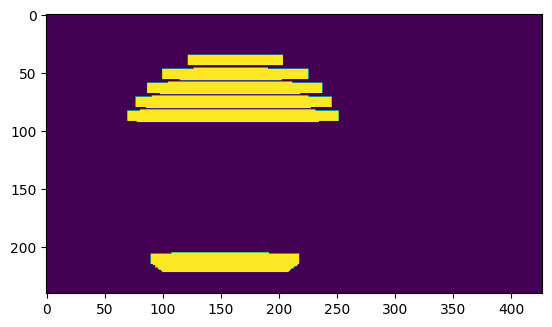

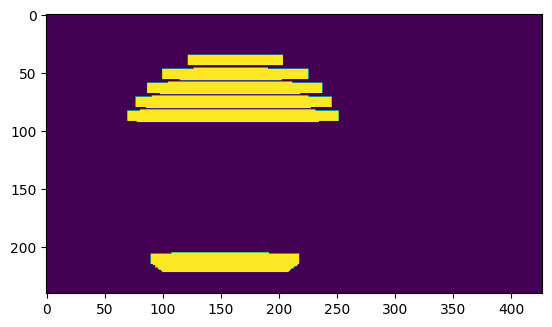

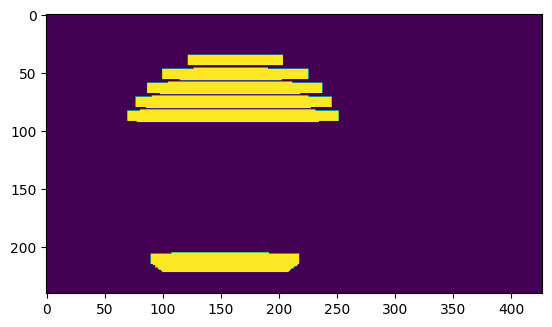

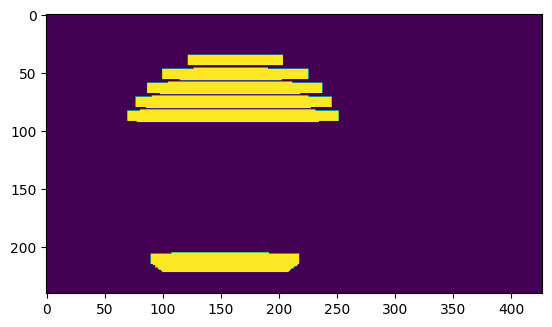

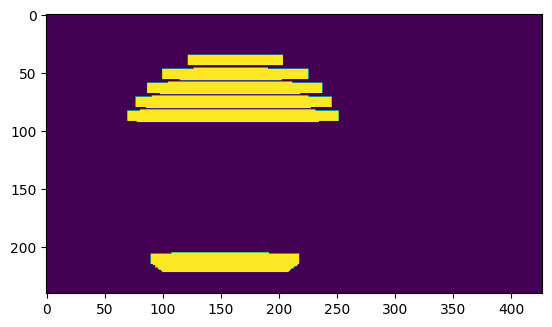

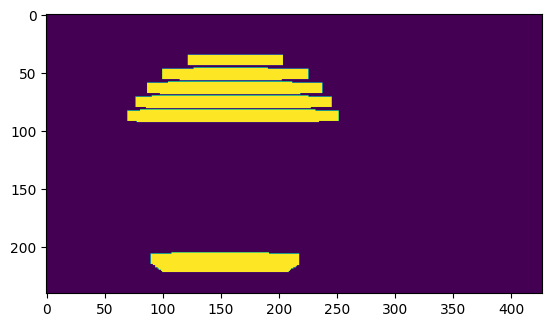

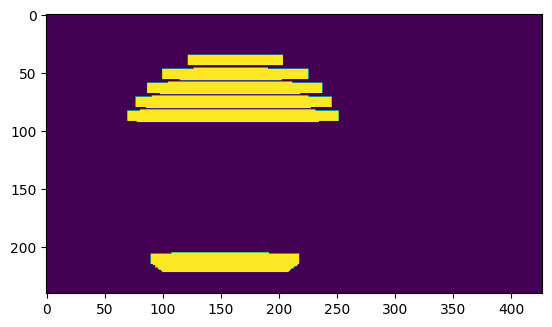

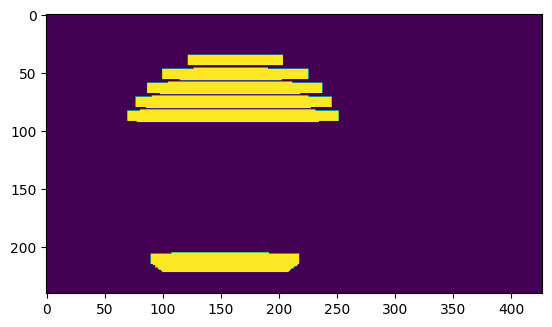

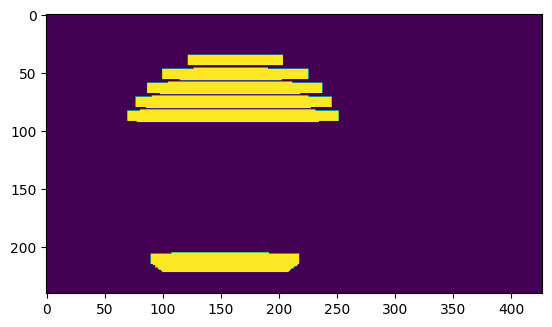

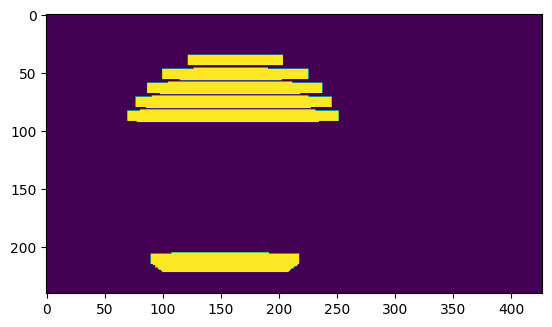

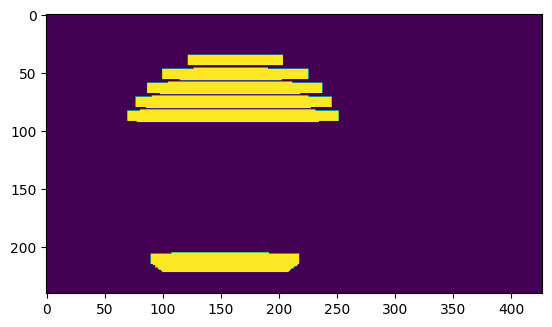

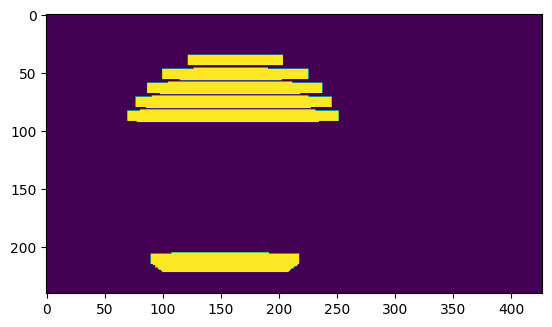

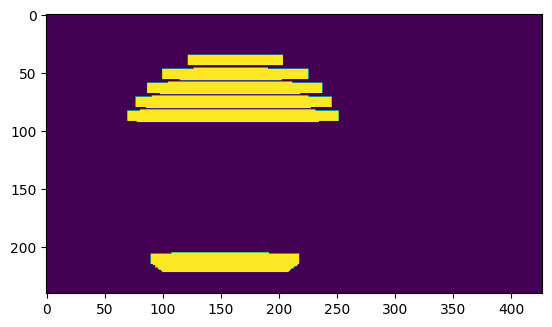

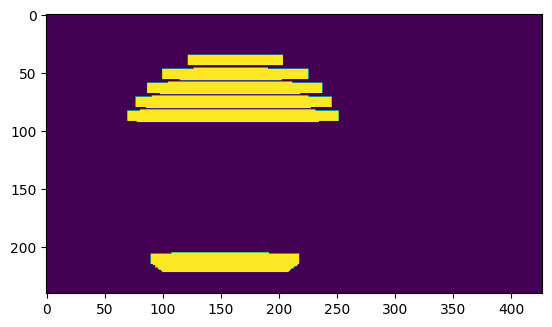

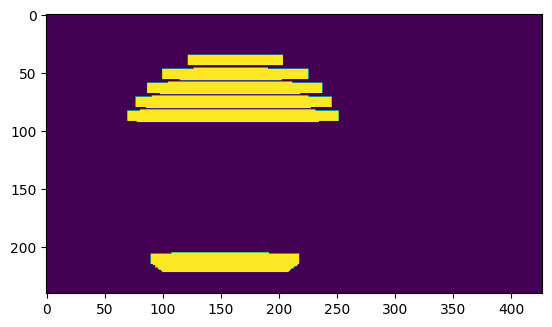

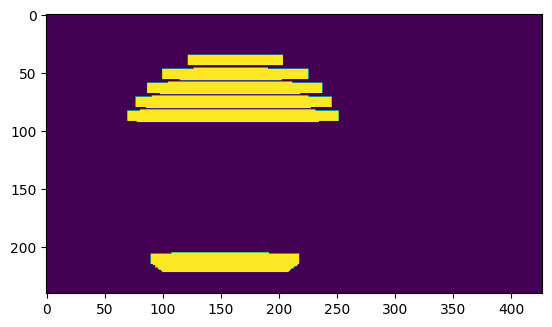

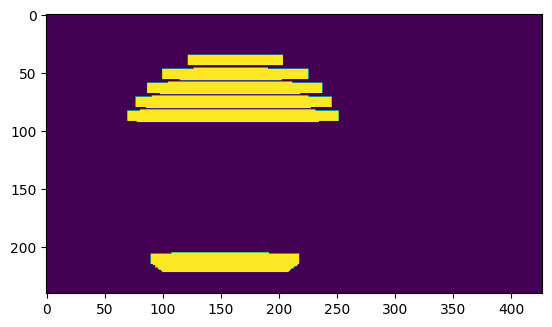

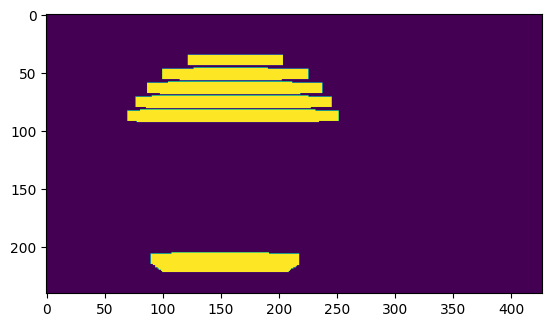

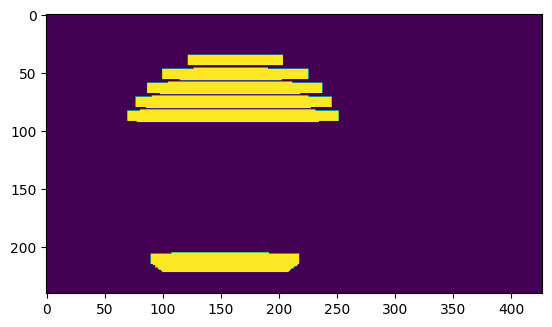

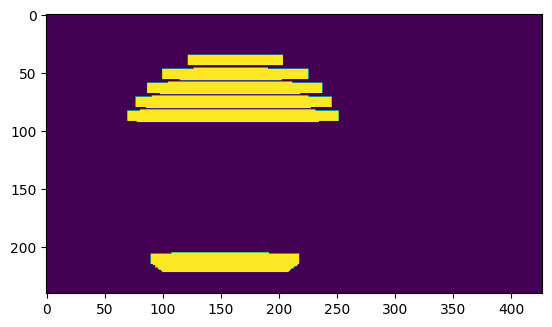

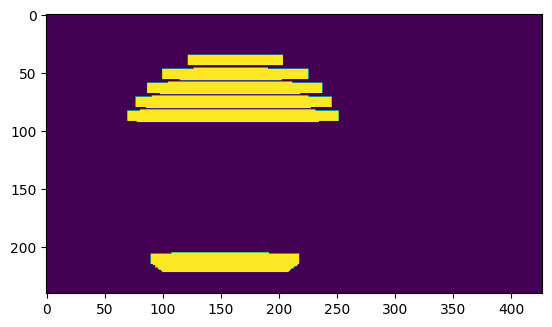

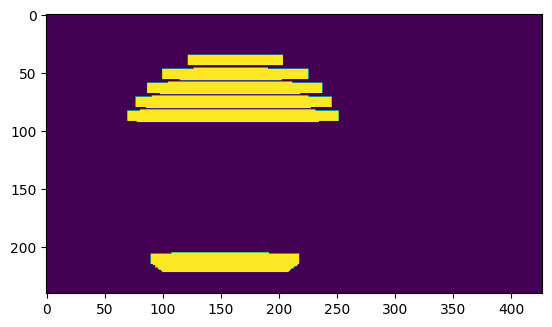

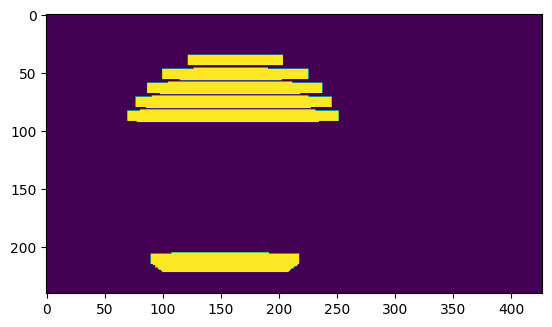

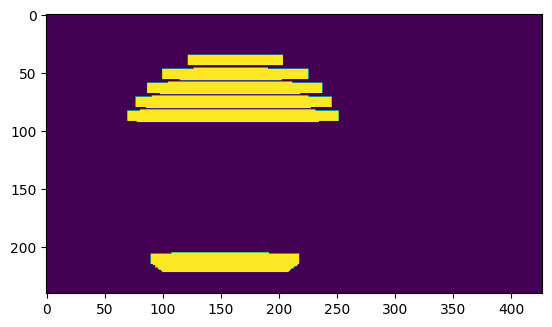

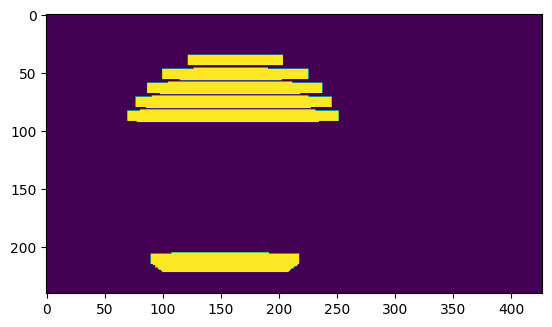

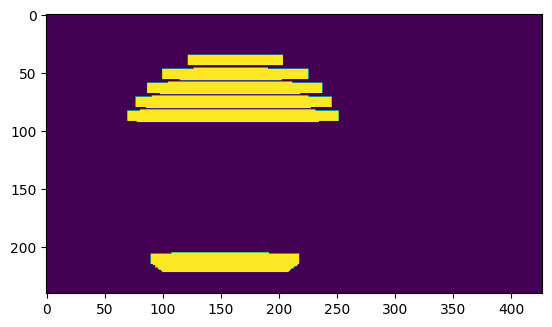

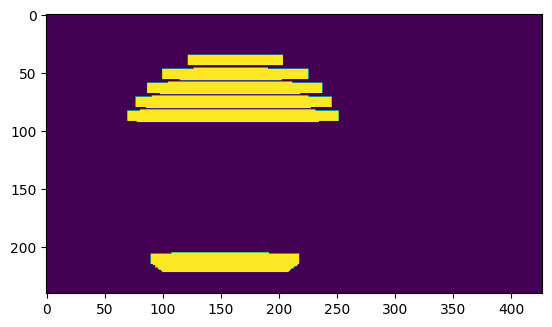

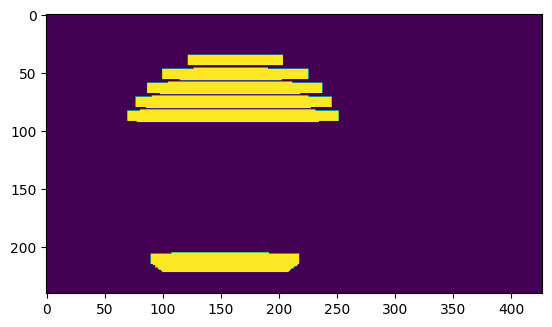

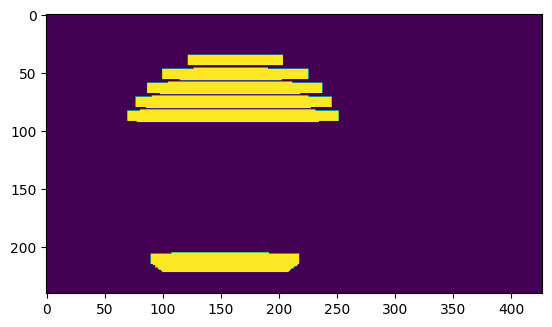

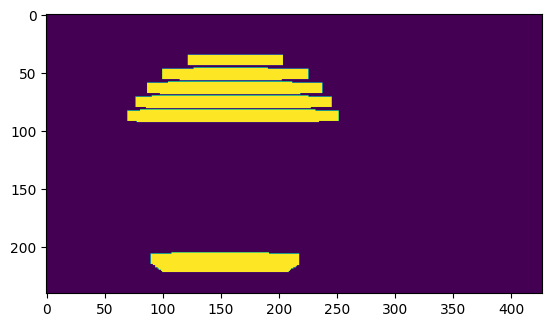

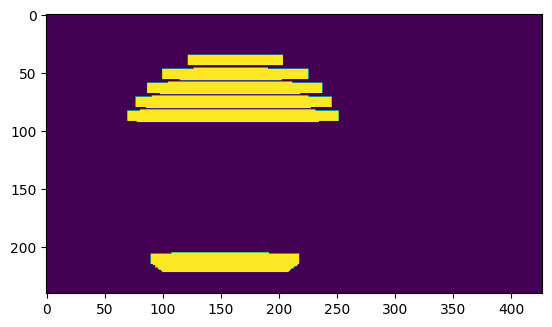

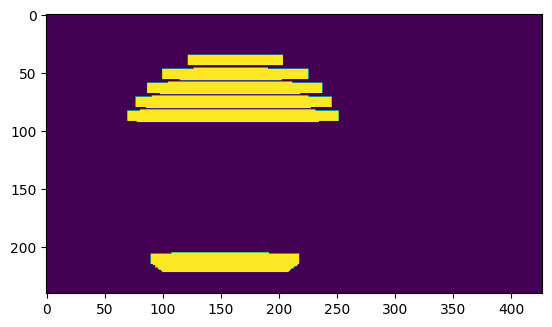

In [46]:
video = "./video.mp4"
cap = cv2.VideoCapture(video)

total = cap.get(cv2.CAP_PROP_FRAME_COUNT)

i = 0

##this is used for saving all of the frames
thresh_list = []
while (cap.isOpened() and i<total):
    ret, frame = cap.read()
    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray,None,fx=0.5,fy=0.5)
#         cv2.imshow('Gray',gray)
        ## SEE IF IT GENERATES THRESHOLD
        # thresh = cv2.threshold(gray, 0 , 255 , cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1] ##need to adjust the second parameter according to the reality
        thresh =cv2.threshold(gray, 80 , 255 , cv2.THRESH_BINARY)[1]
        ##remove bobles noises
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=4)
        thresh_list.append(thresh)    
        cv2.waitKey(60)
        i += 1
print(len(thresh_list))
for thresh in thresh_list:
    plt.imshow(thresh)
    plt.show()
cap.release()
cv2.destroyAllWindows()